# Dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
import xrft
from cdo import Cdo
# cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to clean up the temporary directory
# cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import regionmask
import xskillscore as xs
import pandas as pd
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
import palettable
from shapely.geometry.polygon import LinearRing
import copy
import shutil
import gzip
import warnings

sys.path.append('/home/l/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

with open("/home/l/leach/thesis.mplstyle", "w") as text_file:
    text_file.write(req.content.decode())
    
plt.style.use("/home/l/leach/thesis.mplstyle")
textwidth = matplotlib.rcParams['figure.figsize'][0]

%matplotlib inline

In [2]:
import dask
from dask.distributed import Client, LocalCluster

def setUpCluster(
    n_workers: int, low_workers: int, high_workers: int, memory_limit: int
):
    dask.config.set({"temporary_directory": "/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/"})
    dask.config.set({"array.slicing.split_large_chunks": True})
    dask.config.set({"distributed.worker.memory.spill": 0.8})
    dask.config.set({"distributed.worker.use_file_locking": True})
    # DASK CLUSTER SET UP
    cluster = LocalCluster(
        n_workers=n_workers,
        dashboard_address="localhost:14286",
        memory_limit=f"{memory_limit} GiB",
        threads_per_worker=2,
    )
    cluster.adapt(minimum=low_workers, maximum=high_workers)

    print(f"dashboard : {cluster.dashboard_link}")
    client = Client(cluster)

    return cluster, client

In [3]:
## set up dask
cluster, client = setUpCluster(n_workers= 6, low_workers= 4, high_workers=10, memory_limit=6)

distributed.diskutils - INFO - Found stale lock file and directory '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/tmp/dask-worker-space/worker-9p501u1x', purging


dashboard : http://127.0.0.1:14286/status


# Description
This notebook starts to look into some track / Lagrangian frame analysis of storm Eunice in ERA5 + the forecast experiments.

# General functions
A few preprocessing functions that are used more broadly.

In [4]:
# functions to convert accumulated variables to conventional ones

## accumulated variables & scaling factors
accumulated_vars = {'tp':60 * 60 * 24 * 1e3,'ttr':1,'tsr':1,'str':1,'ssr':1,'e':1}
accumulated_var_newunits = {'tp':'mm day$^{-1}$','ttr':'W m$^{-2}$','tsr':'W m$^{-2}$','str':'W m$^{-2}$','ssr':'W m$^{-2}$','e':'m s$^{-1}$'}

## definition to convert accumulated variables to instantaneous:
def accum2rate(ds):
    ds = ds.copy()
    oindex = ds.time
    inidate = pd.to_datetime(oindex[0].values)
    
    ds = ds.diff('time') / ( ds.time.diff('time').astype(float) / 1e9 )
    ds = ds.reindex(time=oindex)
    return ds[1:]

In [5]:
# main preprocessing function

def preproc_ds(ds):
    
    ds = ds.copy().squeeze()
    
    fname = ds.encoding['source'].split('/')[-1].split('.')[0]
    
    expver = fname.split('_')[0]
    ds = ds.expand_dims({'experiment':[expver]})
    
    # set up aux data
    inidate = pd.to_datetime(ds.time[0].values)
    
    # expand dimensions to include extra info
    if not 'hDate' in ds:
        ds = ds.expand_dims({'inidate':[inidate]})
        
    if not 'number' in ds:
        ds = ds.expand_dims({'number':[0]})
        
    # put time dimension at front
    ds = ds.transpose('time',...)
    
    # convert accumulated variables into instantaneous
    for var,sf in accumulated_vars.items():
        if var in ds.keys():
            ds[var][1:] = accum2rate(ds[var]) * sf
            # set first value to equal zero [since it should be zero... but isn't always]
            ds[var][0] = 0
            ds[var].attrs['units'] = accumulated_var_newunits[var]
            
    return ds

In [6]:
# need a couple more steps for preprocessing the m-climate

def preproc_mclim(ds):
    
    ds = ds.copy().squeeze()
    
    ds = preproc_ds(ds)
    
    # create index of hours from initialisation
    ds_hours = ((ds.time-ds.time.isel(time=0))/1e9/3600).astype(int)
    # change time coord to hours coord + rename
    ds = ds.assign_coords(time=ds_hours).rename(dict(time='hour'))
    
    return ds

In [7]:
def lagrangian_frame(ds):
    ds = ds.squeeze()
    ds = ds.assign_coords(latitude=ds.latitude-ds.centroid_lat,longitude=ds.longitude-ds.centroid_lon)
    ds = ds.rename(latitude='storm_lat',longitude='storm_lon')
    ds = ds.sel(storm_lon=slice(-10,10),storm_lat=slice(10,-10))
    return ds

# OG attempt with CycloneTracking

# TempestExtremes implementation
Seems pretty good once tuned - and arguably more interpretable (since less complex) than CycloneTracking.

In [8]:
def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'1':'ENS','b2nn':'pi','b2nq':'pi','b2ns':'pi','b2no':'incr','b2nr':'incr','b2nt':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df

In [9]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

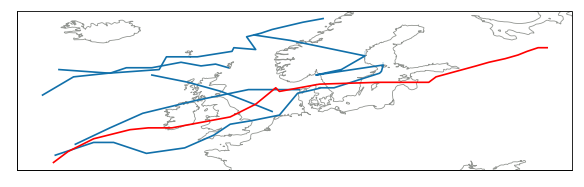

In [10]:
g=sn.relplot(data=ifs_tracks.query('inidate=="2022-02-10" & experiment=="ENS" & number==2'),x='lon',y='lat',size='track_id',sort=False,sizes=(1,1),kind='line',legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())))

sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='r')

g.axes[0,0].coastlines(color='xkcd:grey',lw=0.5)

In [11]:
all_tracks.head()

track_id  year  month  day  hour    i   j   lon    lat       msl        vo  \
0         0  2022      2   14     0  114  62  1.50  58.00  98481.96  0.000082   
1         0  2022      2   14     3  118  61  2.50  58.25  98451.48  0.000102   
2         0  2022      2   14     6  111  70  0.75  56.00  98480.83  0.000113   
3         0  2022      2   14     9  121  68  3.25  56.50  98507.20  0.000095   
4         0  2022      2   14    12  128  65  5.00  57.25  98428.51  0.000175   

  expid experiment    inidate  number                date  
0     1        ENS 2022-02-14       0 2022-02-14 00:00:00  
1     1        ENS 2022-02-14       0 2022-02-14 03:00:00  
2     1        ENS 2022-02-14       0 2022-02-14 06:00:00  
3     1        ENS 2022-02-14       0 2022-02-14 09:00:00  
4     1        ENS 2022-02-14       0 2022-02-14 12:00:00

In [12]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min)).iloc[0]

eunice_filter

date    2022-02-17 09:00:00
day                      26
lon                   -25.5
lat                    47.0
msl                96699.27
Name: (5, 2022-01-01 00:00:00, era5, 0), dtype: object

In [13]:
## starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
## starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
## depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]

Very basic selection criteria to start off with here:

In [14]:
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [15]:
ifs_eunice_list.head()

track_id    inidate experiment  number  year  month  day  hour   i    j  \
0         1 2022-02-14        ENS      25  2022      2   17     9   0  111   
1         1 2022-02-14        ENS      25  2022      2   17    12   1  108   
2         1 2022-02-14        ENS      25  2022      2   17    15  10  105   
3         1 2022-02-14        ENS      25  2022      2   17    18  21   99   
4         1 2022-02-14        ENS      25  2022      2   17    21  30   95   

     lon    lat        msl        vo expid                date  
0 -27.00  45.75  100150.40  0.000130     1 2022-02-17 09:00:00  
1 -26.75  46.50   99387.10  0.000238     1 2022-02-17 12:00:00  
2 -24.50  47.25   99108.85  0.000457     1 2022-02-17 15:00:00  
3 -21.75  48.75   98643.55  0.000504     1 2022-02-17 18:00:00  
4 -19.50  49.75   97933.05  0.000611     1 2022-02-17 21:00:00

Secondary filter to ensure each member only has a single track. Select track based on closeness to ERA5 track.

In [16]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

In [17]:
multi_track_members

year
inidate    experiment number      
2022-02-10 ENS        14         2
2022-02-14 incr       9          2
                      28         2
                      41         2
           pi         1          2
                      22         2
2022-02-16 pi         17         2

In [18]:
def eunice_dist(df):
    
    eunice_lons = eunice_track.lon.values
    eunice_lats = eunice_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(eunice_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-eunice_lons[:minsize])**2+(track_lats[:minsize]-eunice_lats[:minsize])**2).sum()

In [19]:
for idx in multi_track_members.index:
    
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(eunice_dist)
    
    num_reject = track_dists.idxmax()
    
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  """Entry point for launching an IPython kernel.
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fa57d6311d0>>, <Task finished coro=<Worker.close() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/worker.py:1593> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:35586 remote=tcp://127.0.0.1:37303>: Stream is closed')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed



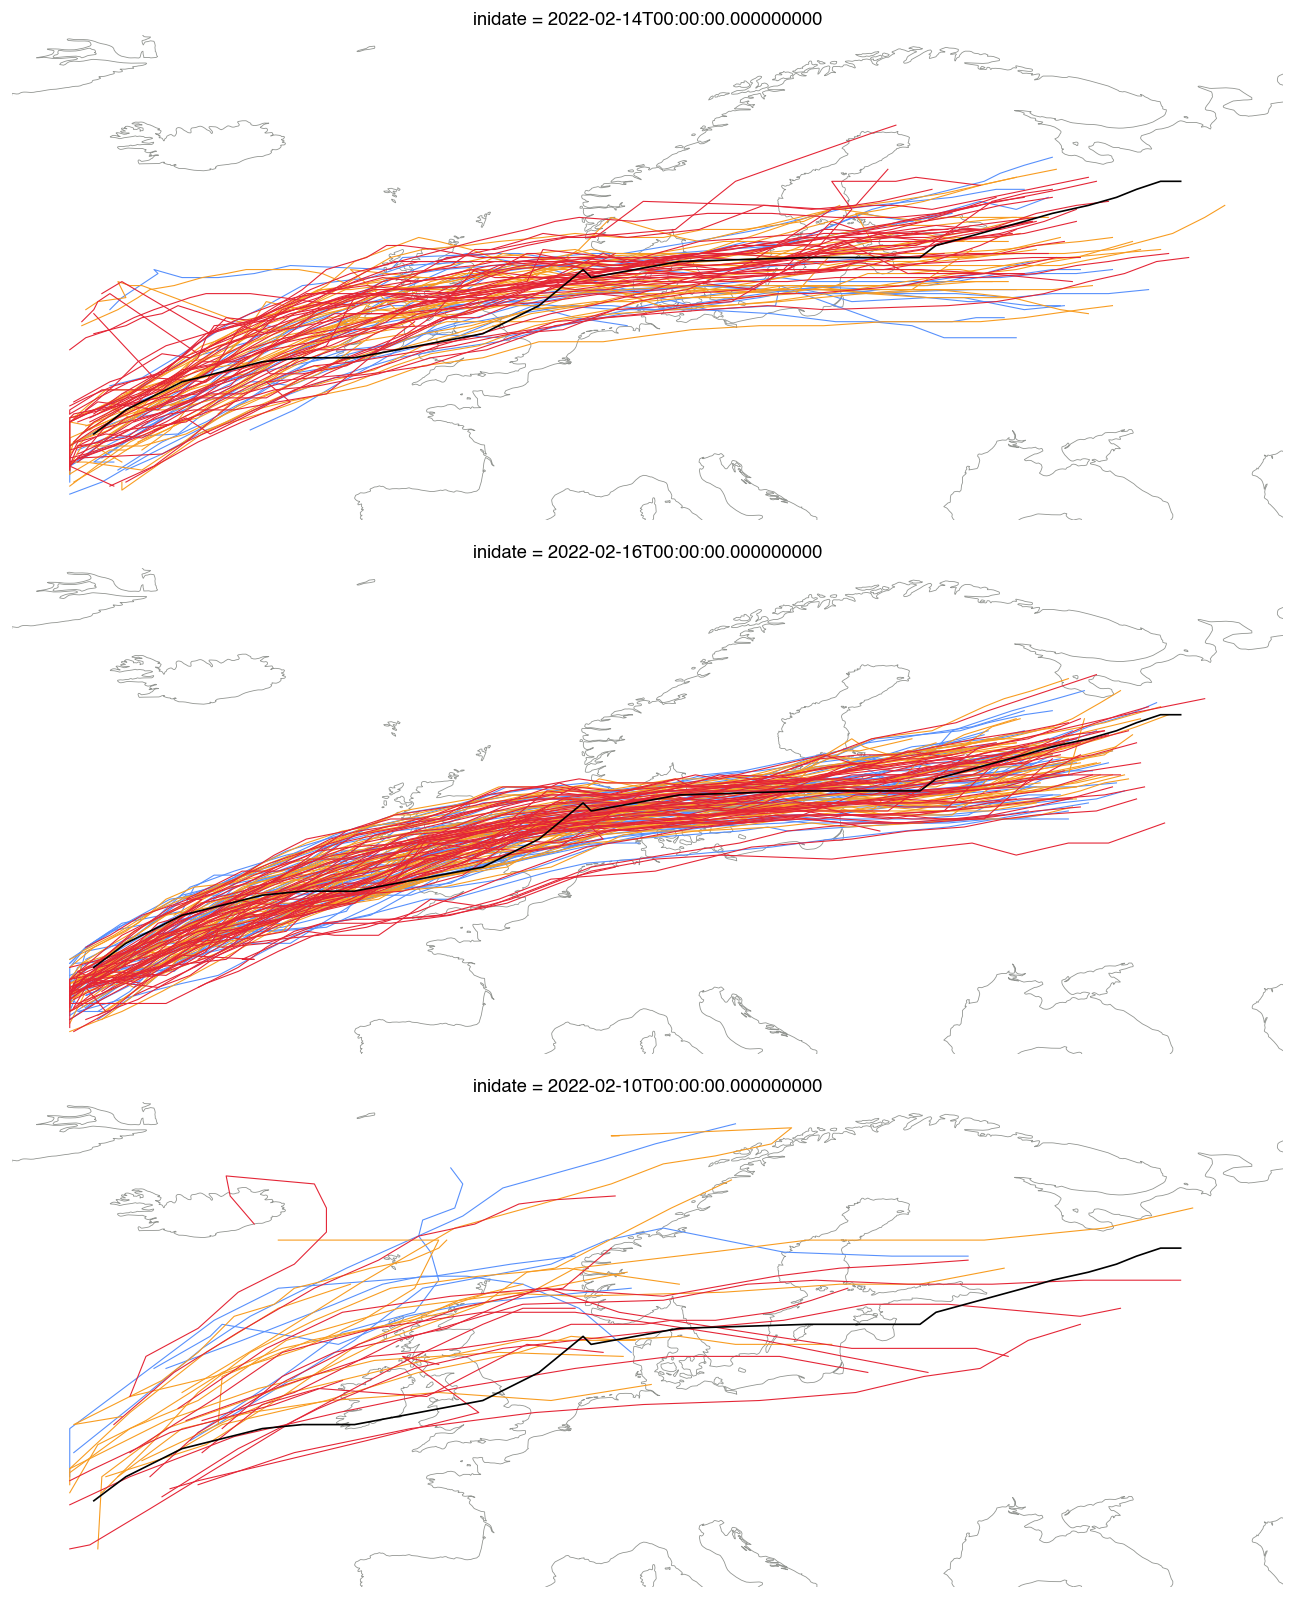

In [20]:
g=sn.relplot(data=ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])],x='lon',y='lat',row='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),size='number',sort=False,estimator=None,sizes=(0.66,0.66),kind='line',height=4.5,legend=False,facet_kws=dict(subplot_kws=dict(projection=crs.PlateCarree())),aspect=3)

[sn.lineplot(data=eunice_track,x='lon',y='lat',legend=False,color='k',ax=a) for a in g.axes.flatten()]
[a.coastlines(color='xkcd:grey',lw=0.5) for a in g.axes.flatten()]
[a.axis('off') for a in g.axes.flatten()];

In [21]:
ifs_eunice_list_stats = ifs_eunice_list.loc[ifs_eunice_list.inidate.isin(['2022-02-10','2022-02-14','2022-02-16'])].groupby(['experiment','inidate','number','track_id']).agg(dict(msl=min,date=min,vo=max)).reset_index()
ifs_eunice_list_stats['date'] = (ifs_eunice_list_stats.date - eunice_filter.date).dt.total_seconds()/(3600*24)

distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing


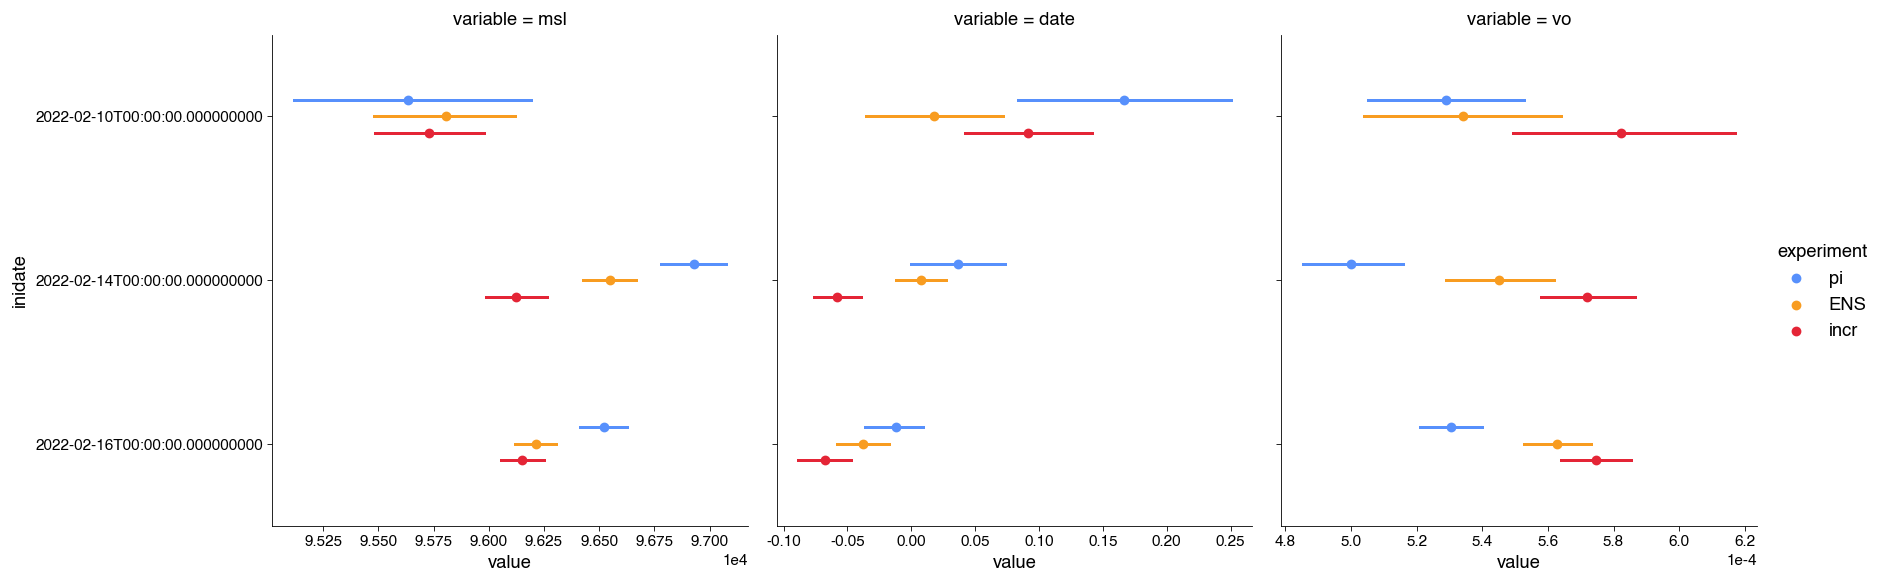

In [22]:
sn.catplot(data=ifs_eunice_list_stats.set_index(['experiment','inidate']).drop(['track_id','number'],axis=1).stack().astype(float).reset_index().rename({'level_2':'variable',0:'value'},axis=1),
           x='value',col='variable',y='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),kind='point',join=False,dodge=0.2,errorbar=('ci',66),n_boot=10000,sharex=False)

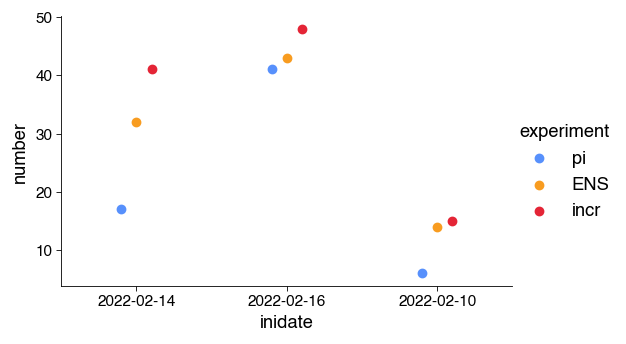

In [23]:
sn.catplot(data=ifs_eunice_list.assign(inidate=lambda x: x.inidate.dt.date),x='inidate',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),y='number',estimator=lambda x: np.unique(x).size,kind='point',dodge=0.2,join=False,height=3,aspect=1.5)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  


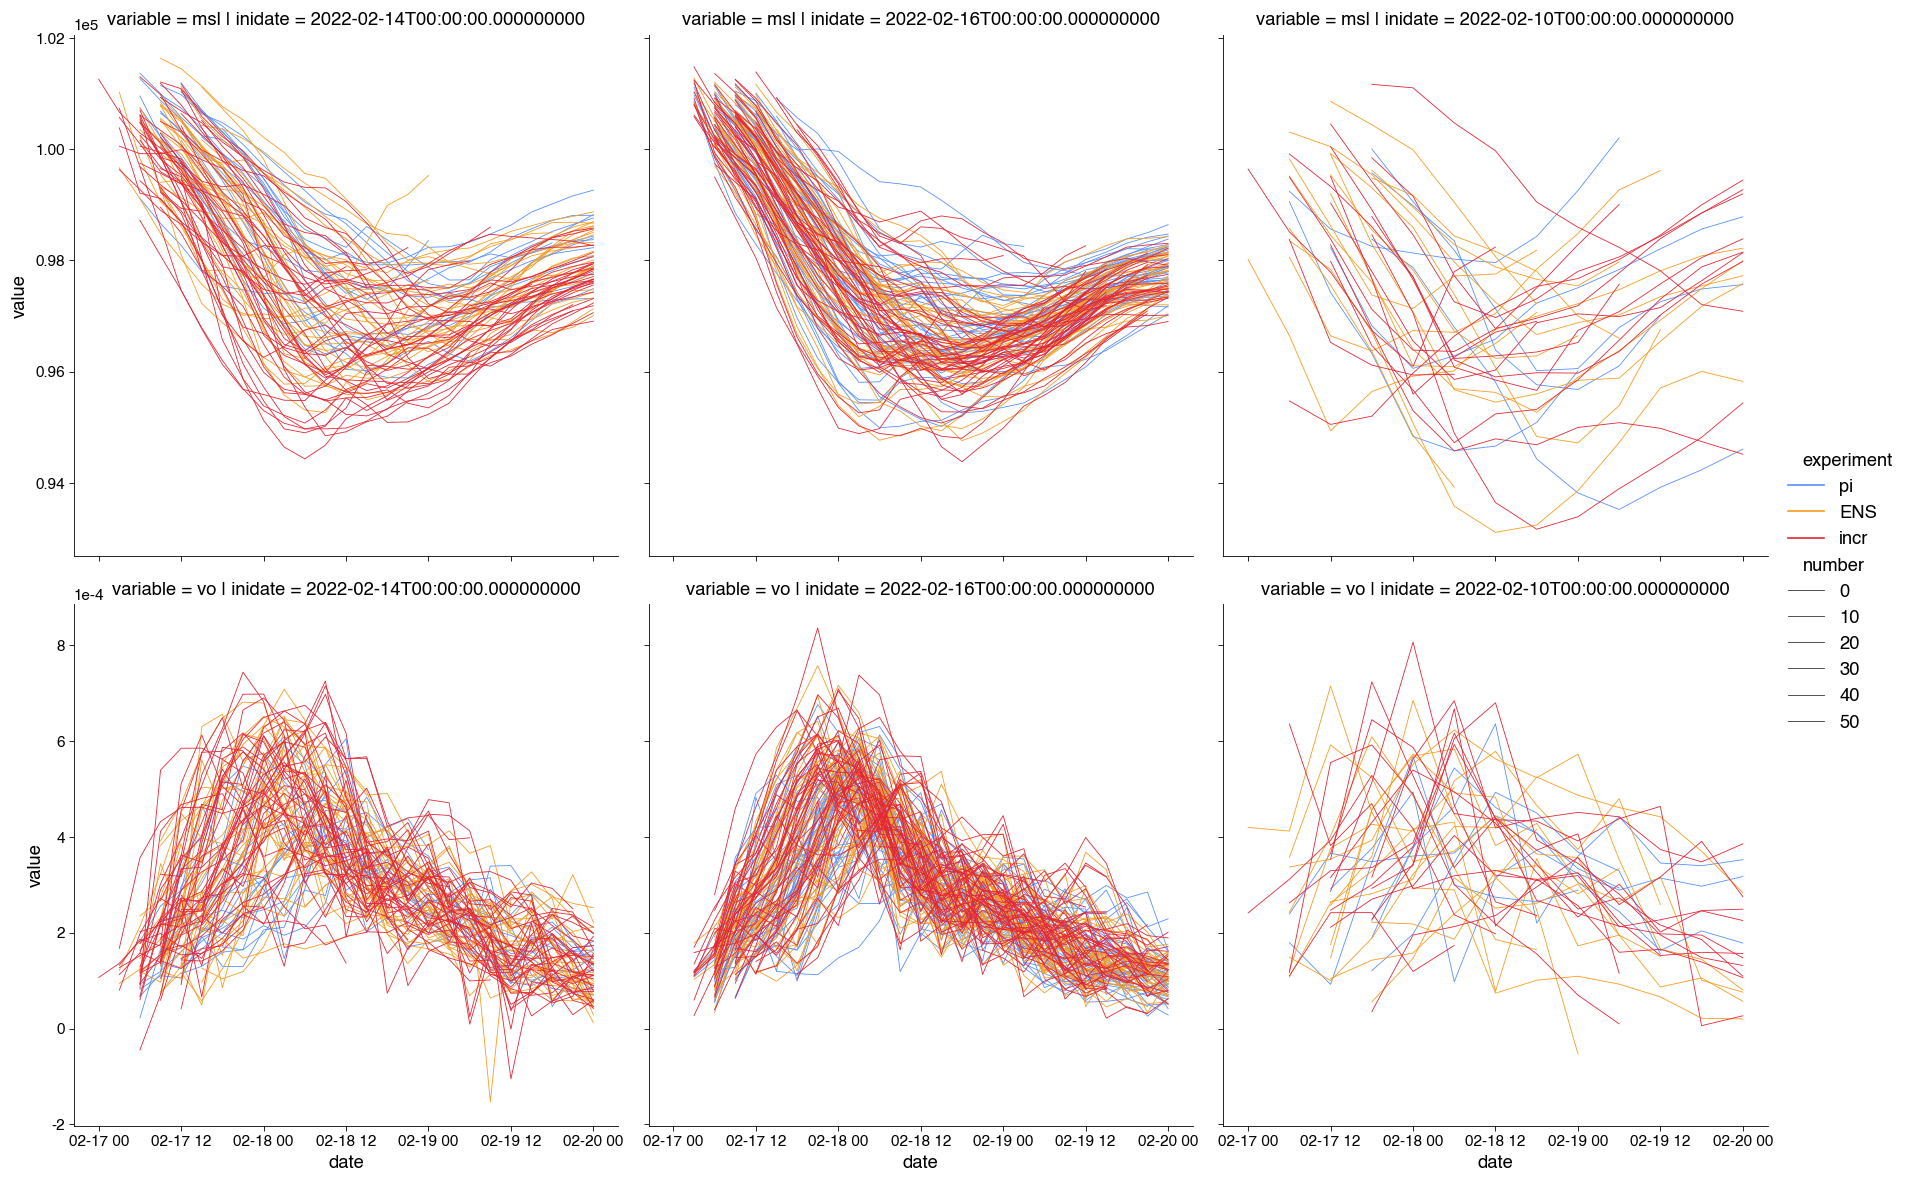

In [24]:
sn.relplot(data=ifs_eunice_list.set_index(['inidate','experiment','number','date']).loc[:,['msl','vo']].stack().reset_index().rename({'level_4':'variable',0:'value'},axis=1),
          x='date',y='value',row='variable',col='inidate',hue_order=['pi','ENS','incr'],hue='experiment',size='number',sizes=(0.5,0.5),estimator=None,sort=False,kind='line',facet_kws=dict(sharey='row'),palette=get_palette.Petroff6().to_sn_palette())

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  


(-27.1375, 36.3875, 44.9625, 67.7875)

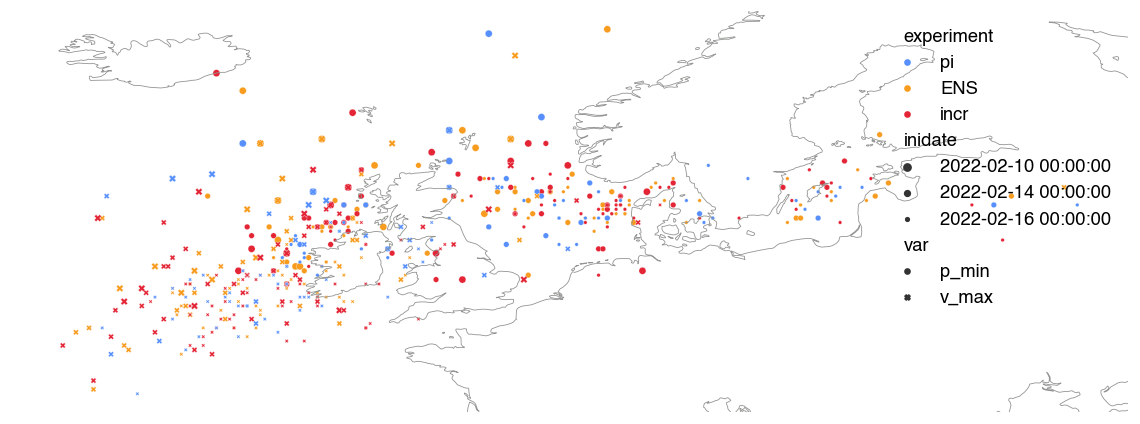

In [25]:
fig,ax = plt.subplots(subplot_kw=dict(projection=crs.PlateCarree()),figsize=(12,5))

g=sn.scatterplot(data=pd.concat([
ifs_eunice_list.groupby(['experiment','inidate','number']).apply(lambda x: x.loc[x.msl.idxmin()])[['msl','lon','lat']].rename({'msl':'value'},axis=1).assign(var='p_min'),
ifs_eunice_list.groupby(['experiment','inidate','number']).apply(lambda x: x.loc[x.vo.idxmax()])[['vo','lon','lat']].rename({'vo':'value'},axis=1).assign(var='v_max'),]).reset_index(),
              x='lon',y='lat',style='var',hue='experiment',hue_order=['pi','ENS','incr'],palette=get_palette.Petroff6().to_sn_palette(),size='inidate',ax=ax)

ax.coastlines(color='xkcd:grey',lw=0.5)

ax.axis('off')

## Bit of Lagrangian frame work

### Importing storm frame fields

In [26]:
def preproc_to_stormframe(ds):
    
    ds = ds.copy()
    
    if not 'number' in ds.coords:
        ds = ds.expand_dims({'number':[0]})
        
    fpath = ds.encoding['source']
    
    exp = fpath.split('/')[-5]
    inidate = fpath.split('/')[-1].split('_')[-1].split('.')[0]
    
    ds_tracks = ifs_eunice_list.query('experiment=="{}" & inidate=="{}"'.format(exp,inidate))

    LG_fields = []

    for num in set(ds.number.values).intersection(ds_tracks.number.unique()):

        mem_track = ds_tracks.loc[ds_tracks.number==num]
        mem_fields = ds.sel(number=num)
        time_intersection = sorted(list(set(mem_fields.time.values).intersection(mem_track.date.values)))
        
        resample_freq = 3 ## resampling frequency in hours
        if inidate == '2022-02-10':
            resample_freq = 6
        
        ## get start / end times for properly calculating the maximum fields (taking into account the different preproc times in IFS)
        time_start = time_intersection[0]-pd.Timedelta('{}h 59m'.format(resample_freq-1))
        time_end = time_intersection[-1]

        ## get the instantaneous fields + wind speeds
        mem_fields_out = mem_fields.get(['sst','u10','v10','msl','u100','v100','tcwv']).sel(time = time_intersection)
        mem_fields_out['ws10'] = np.sqrt(mem_fields_out.u10**2+mem_fields_out.v10**2)
        mem_fields_out['ws100'] = np.sqrt(mem_fields_out.u100**2+mem_fields_out.v100**2)
        
        ## get the maximum fields, taking into account the different preproc times
        mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start,time_end)).resample(time='{}h'.format(resample_freq),label='right',closed='right',base=0).max()
        mem_fields_out['mxtpr'] = mxtpr_field_out

        ## add in the mslp centroid lon/lats for Lagrangian analysis 
        mem_track_out = mem_track.loc[mem_track.date.isin(time_intersection)]
        mem_fields_out['centroid_lon'] = ('time',(mem_track_out.lon*4).round()/4)
        mem_fields_out['centroid_lat'] = ('time',(mem_track_out.lat*4).round()/4)

        ## convert to storm frame fields
        mem_fields_out = mem_fields_out.groupby('time').apply(lagrangian_frame)
        mem_fields_out = mem_fields_out.assign(datetime=mem_fields_out.time).drop('time').rename(time='timestep')
        
        ## compute the time of peak vorticity (include moving average to smooth) for storm composites
        peak_vo = mem_track.rolling(3,center=True).mean().vo.idxmax()
        peak_vo_datetime = mem_track.date.loc[peak_vo]
        peak_vo_relative_time = (mem_fields_out.datetime.squeeze().to_pandas() - peak_vo_datetime).dt.total_seconds().values/(3600*24)

        ## set the storm frame fields timestep relative to peak vorticity time
        mem_fields_out = mem_fields_out.assign_coords(timestep=peak_vo_relative_time)

        LG_fields += [mem_fields_out]
        
    LG_fields = xr.concat(LG_fields,'number')
    
    LG_fields = LG_fields.expand_dims(dict(inidate=[pd.to_datetime(inidate)],experiment=[exp]))
    
    return LG_fields

In [27]:
ens_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',preprocess=preproc_to_stormframe,combine='nested',concat_dim=['inidate'],parallel=True)

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 14
  **blockwise_kwargs,
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/co

### Figures

#### What do the storms look like at the time of peak vorticity at each lead?

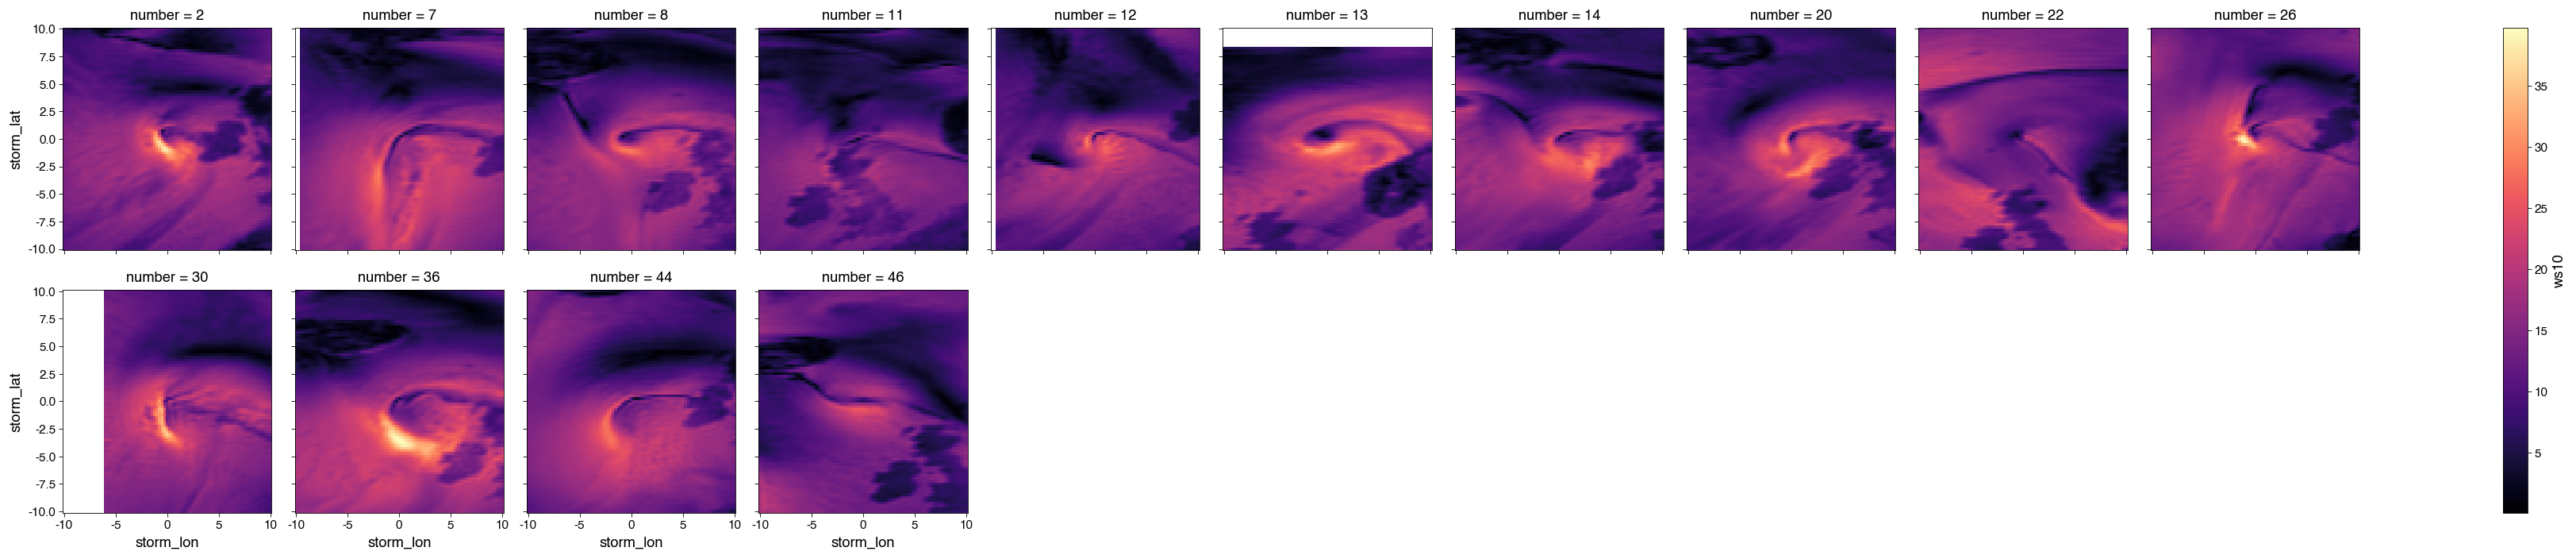

In [28]:
ens_storms.sel(inidate='2022-02-10').sel(timestep=0).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

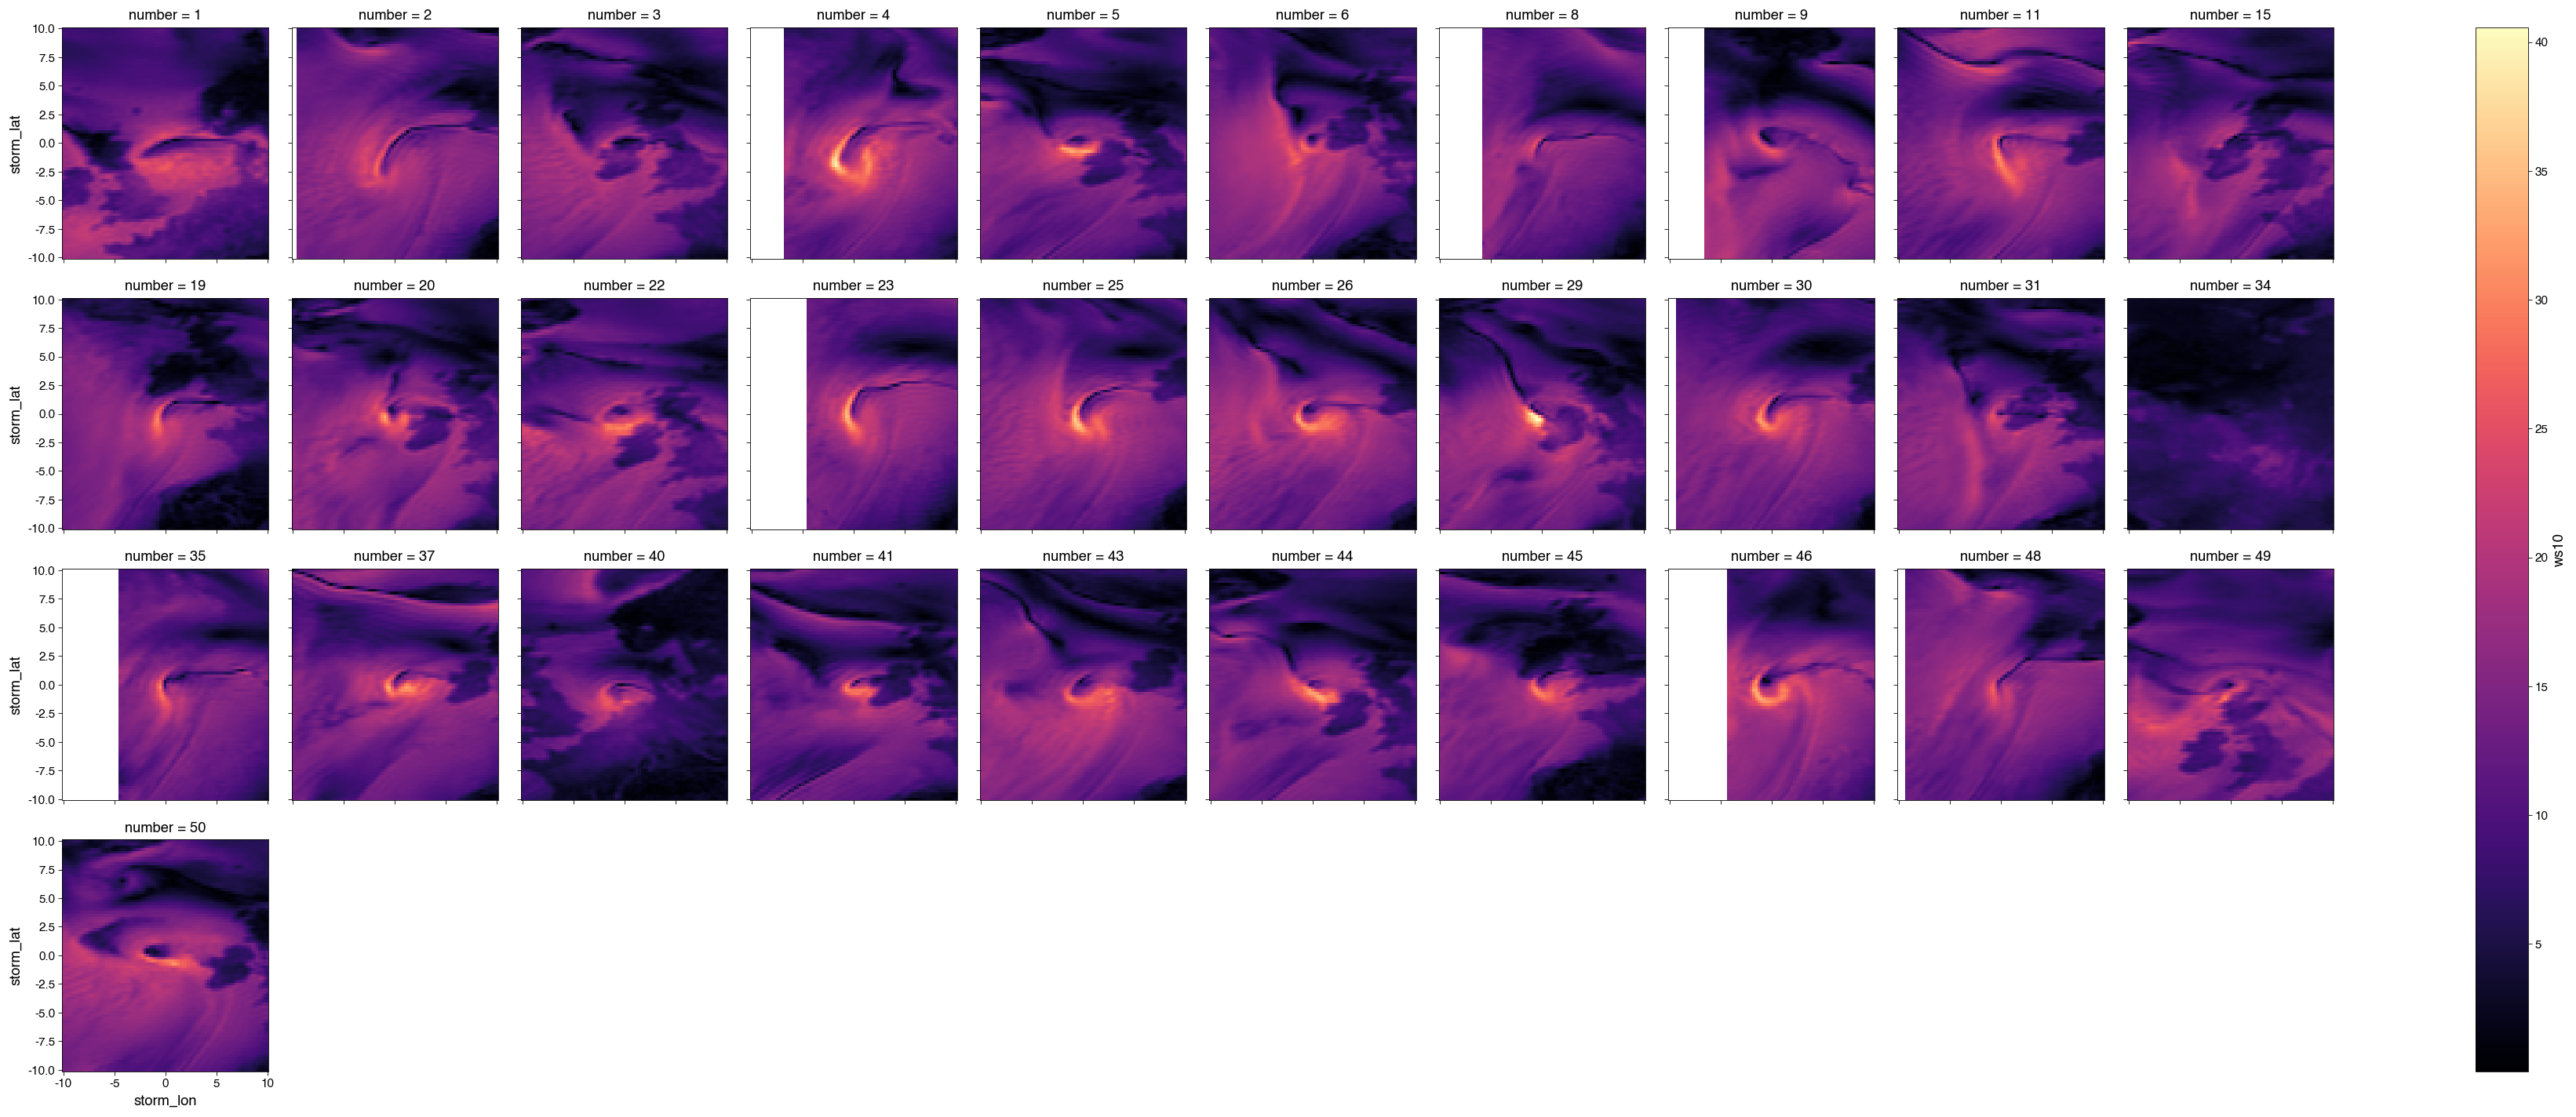

In [29]:
ens_storms.sel(inidate='2022-02-14').sel(timestep=0).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

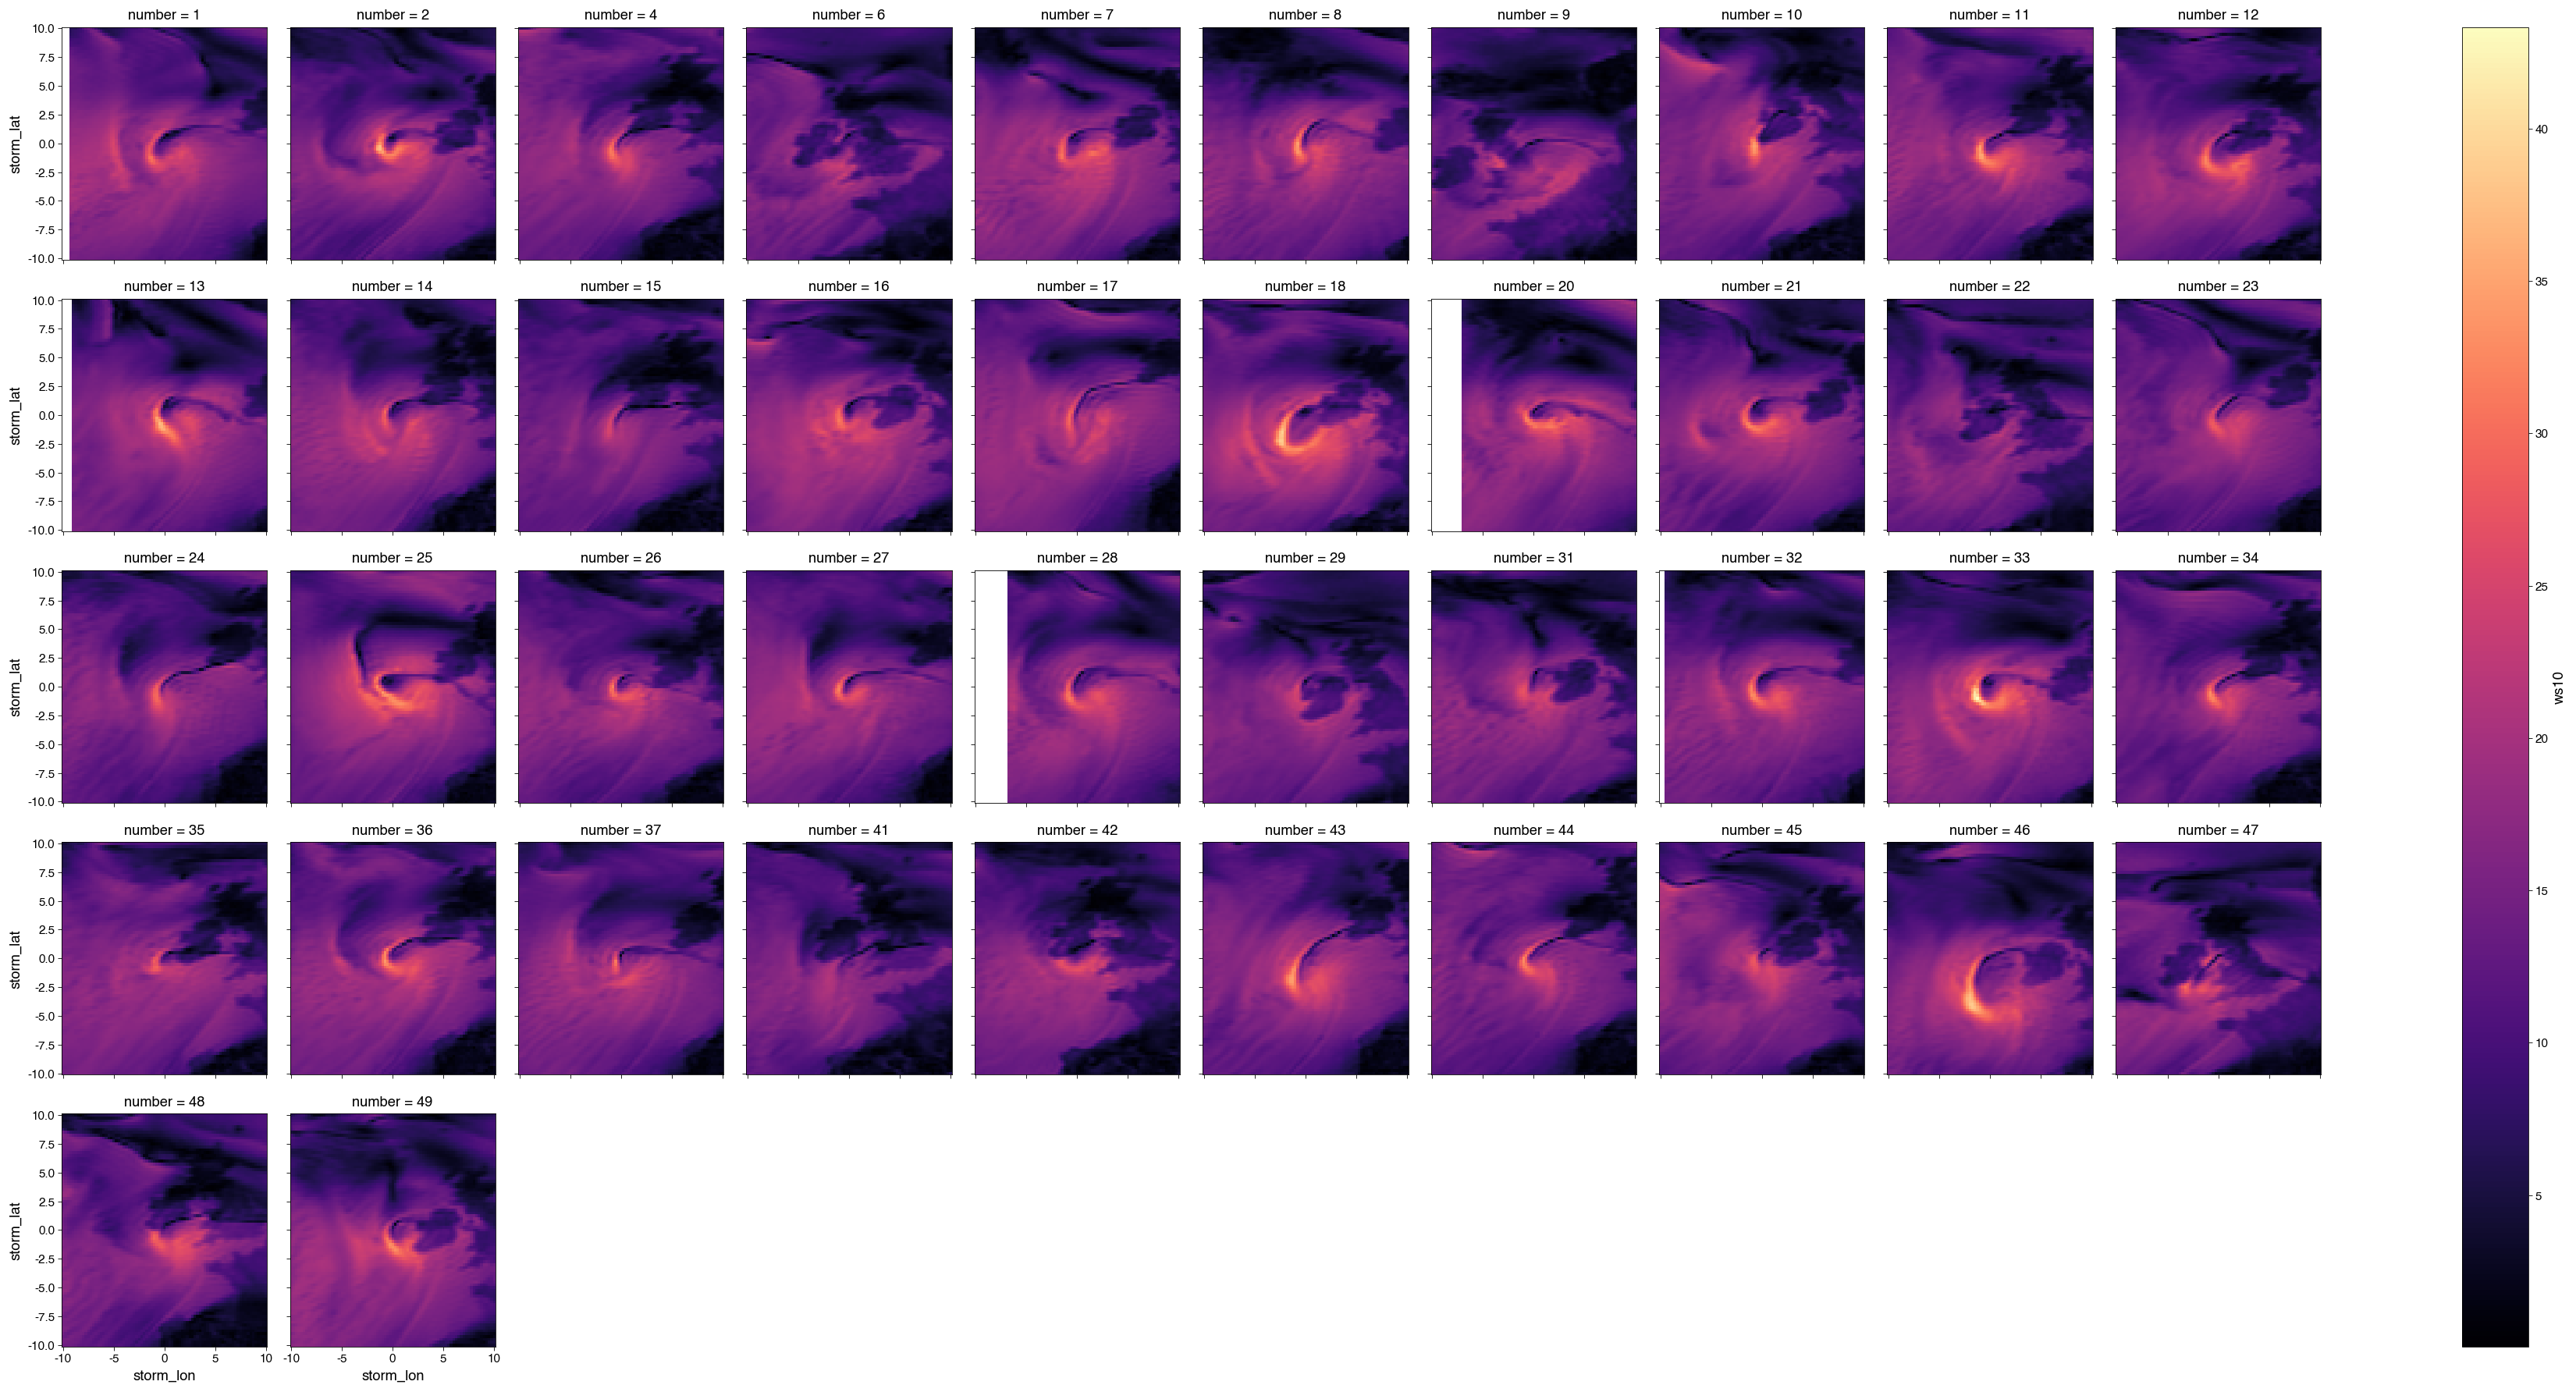

In [30]:
ens_storms.sel(inidate='2022-02-16').sel(timestep=0).ws10.dropna('number',how='all').plot(col='number',col_wrap=10,cmap='magma')

#### Response to CO2

Wind speed (at 100m to reduce influence of surface friction)

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7f7821c94bd0>>, <Task finished coro=<Worker.close() done, defined at /home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/worker.py:1593> exception=CommClosedError('in <TCP (closed) ConnectionPool.close_gracefully local=tcp://127.0.0.1:34240 remote=tcp://127.0.0.1:43495>: Stream is closed')>)
Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret =

distributed.nanny - WARNING - Worker process still alive after 3.999998092651367 seconds, killing


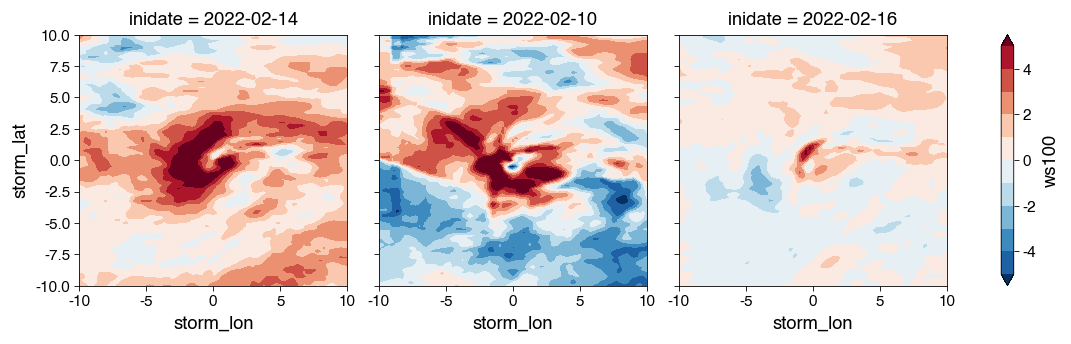

In [31]:
(incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

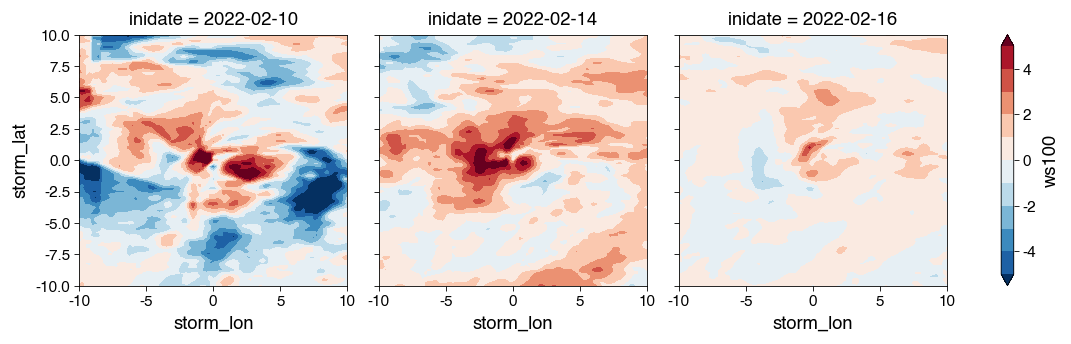

In [32]:
(ens_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

mslp

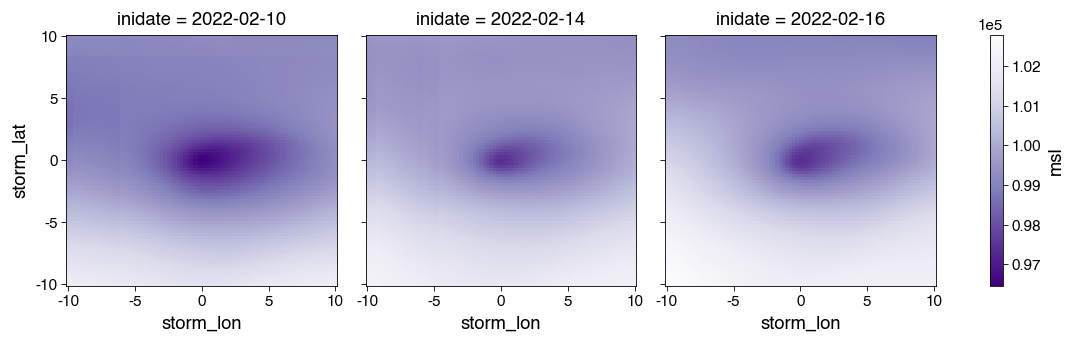

In [44]:
ens_storms.msl.sel(timestep=0).mean('number').plot(col='inidate',cmap='Purples_r')

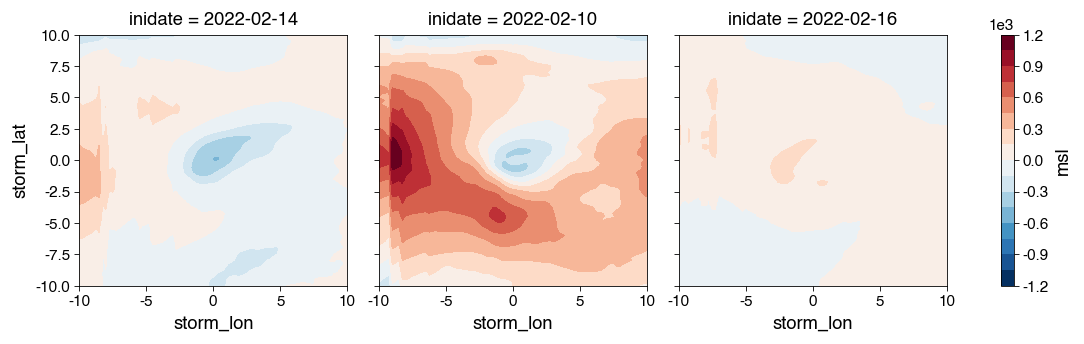

In [39]:
(incr_storms.msl.sel(timestep=0).mean('number').squeeze() - pi_storms.msl.sel(timestep=0).mean('number').squeeze()).plot.contourf(col='inidate',levels=20)

total column water vapour

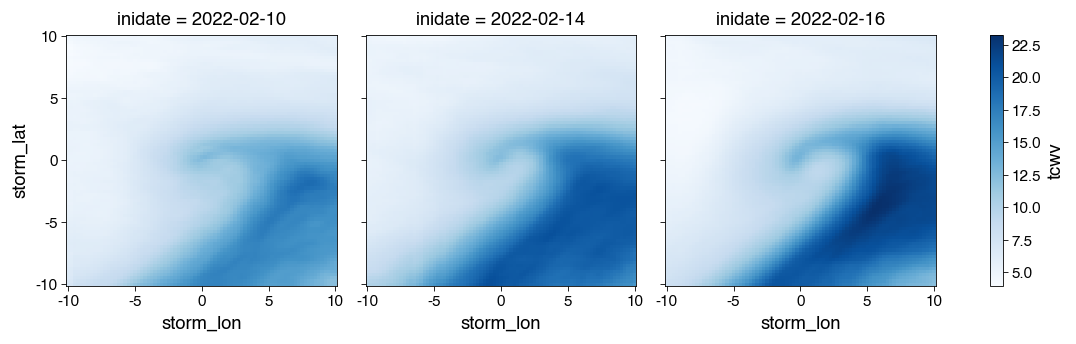

In [45]:
ens_storms.tcwv.sel(timestep=0).mean('number').plot(col='inidate',cmap='Blues')

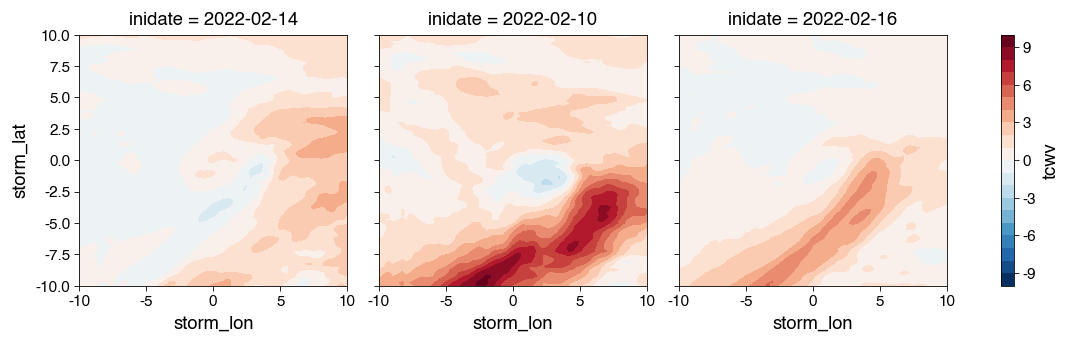

In [40]:
(incr_storms.tcwv.sel(timestep=0).mean('number').squeeze() - pi_storms.tcwv.sel(timestep=0).mean('number').squeeze()).plot.contourf(col='inidate',levels=20)

max precipitation rate

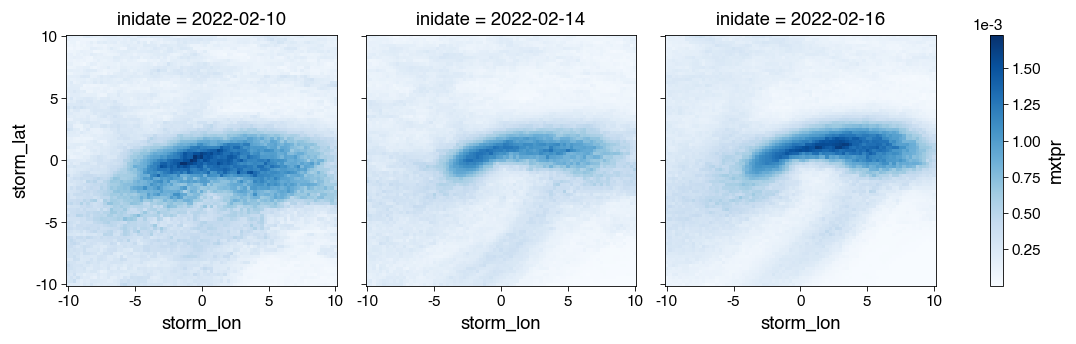

In [42]:
ens_storms.mxtpr.sel(timestep=0).mean('number').plot(col='inidate',cmap='Blues')

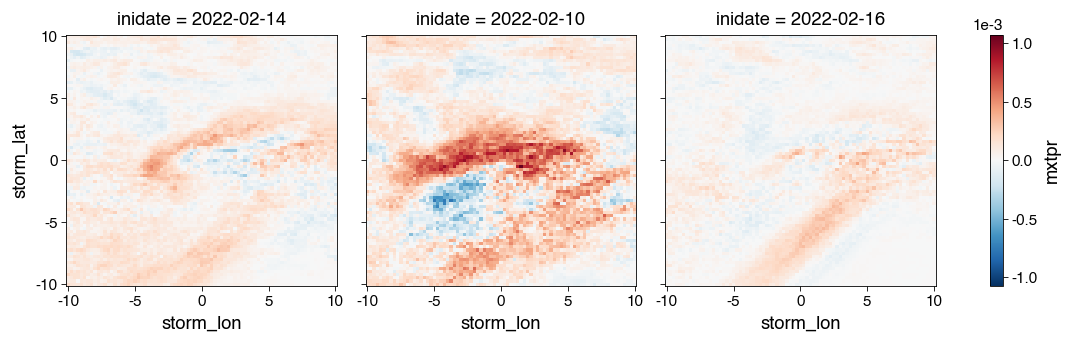

In [36]:
(incr_storms.mxtpr.sel(timestep=0).mean('number').squeeze() - pi_storms.mxtpr.sel(timestep=0).mean('number').squeeze()).plot(col='inidate')

## Some plots by timestep
Here we'll plot up to 1 day before / after the storm reaches peak vorticity

wind speeds

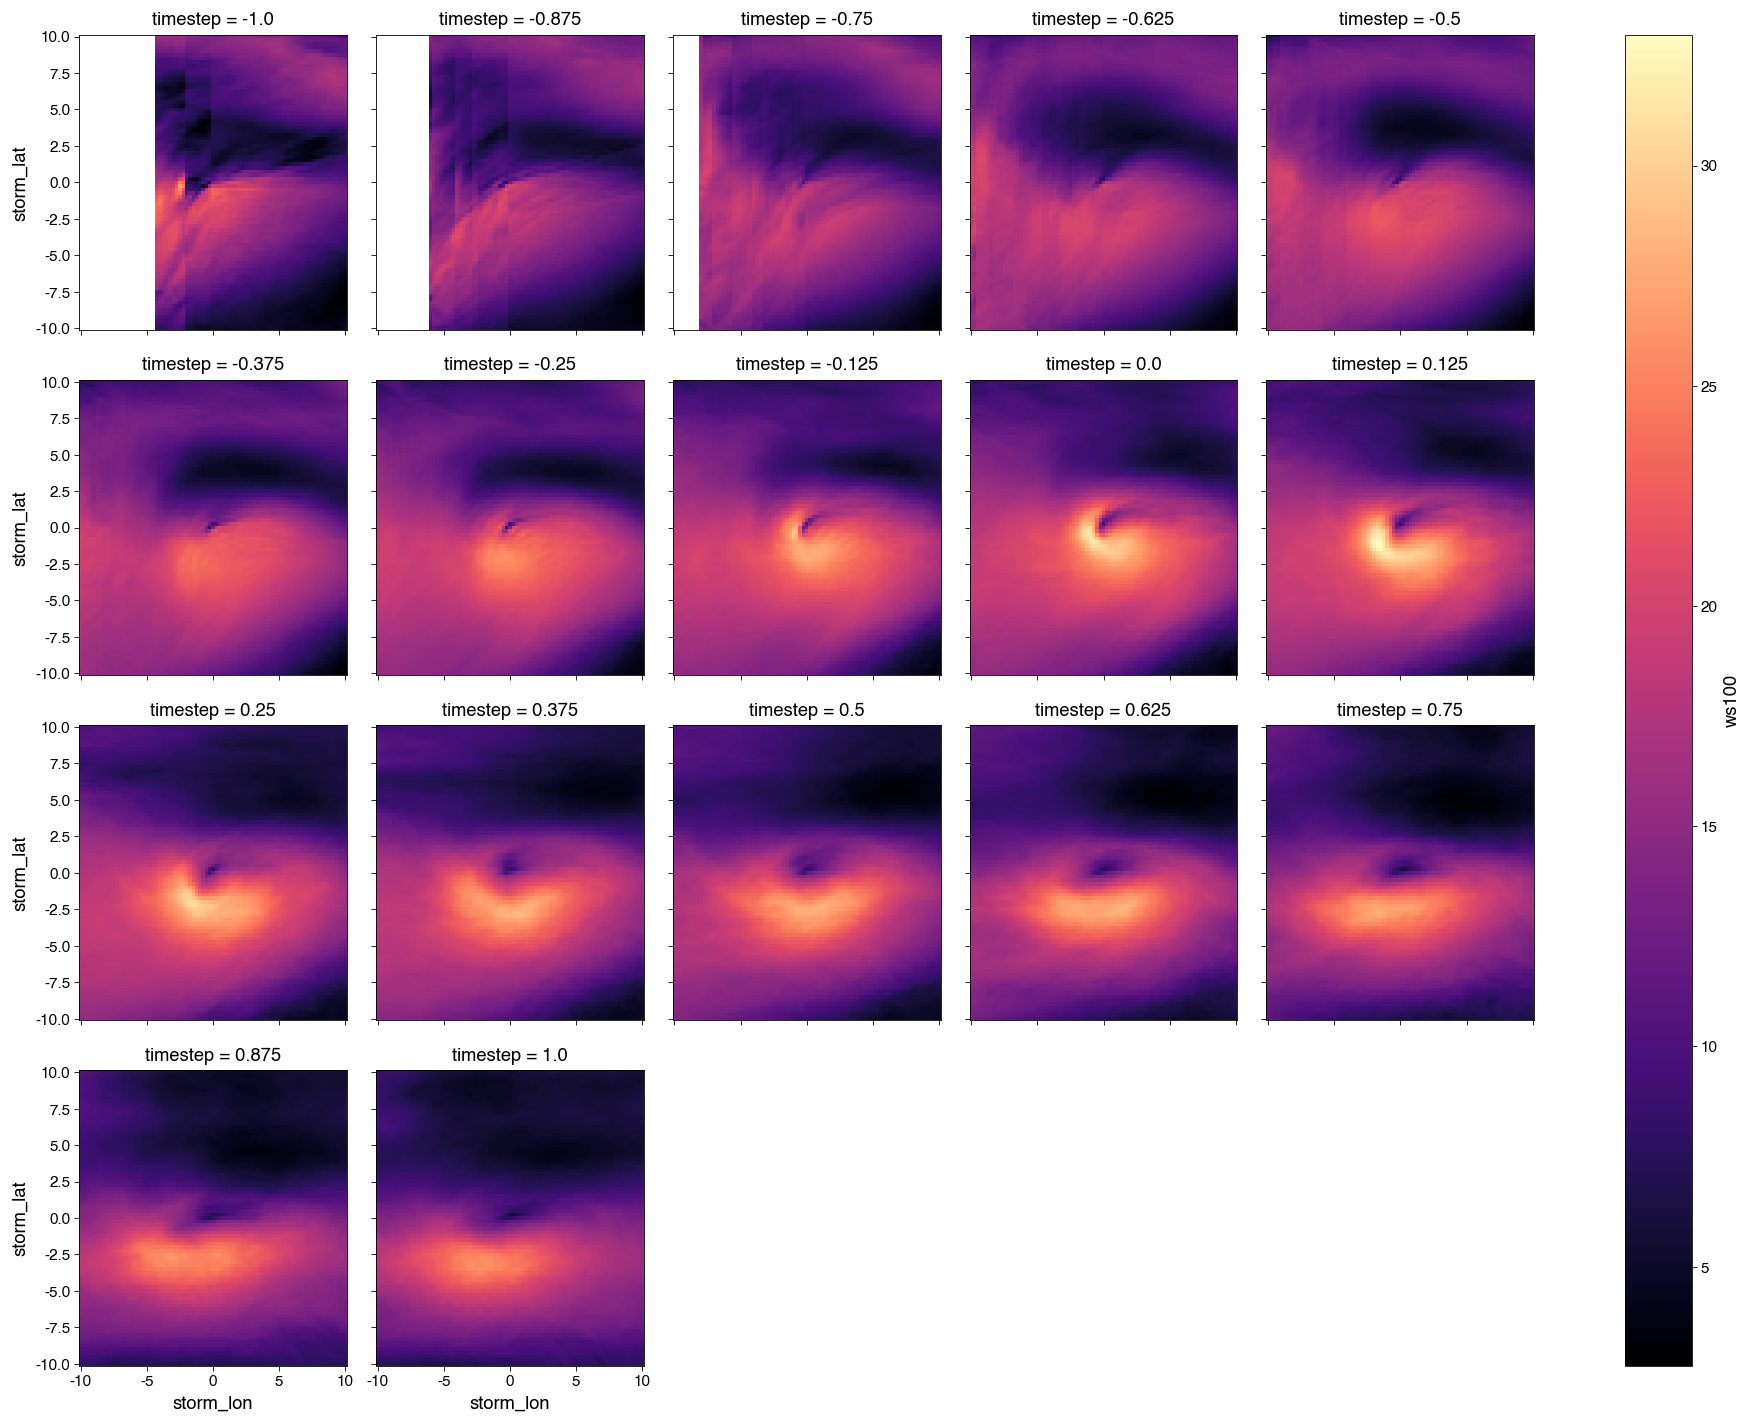

In [47]:
ens_storms.sel(inidate='2022-02-16',timestep=slice(-1,1)).ws100.mean('number').plot(col='timestep',cmap='magma',col_wrap=5)

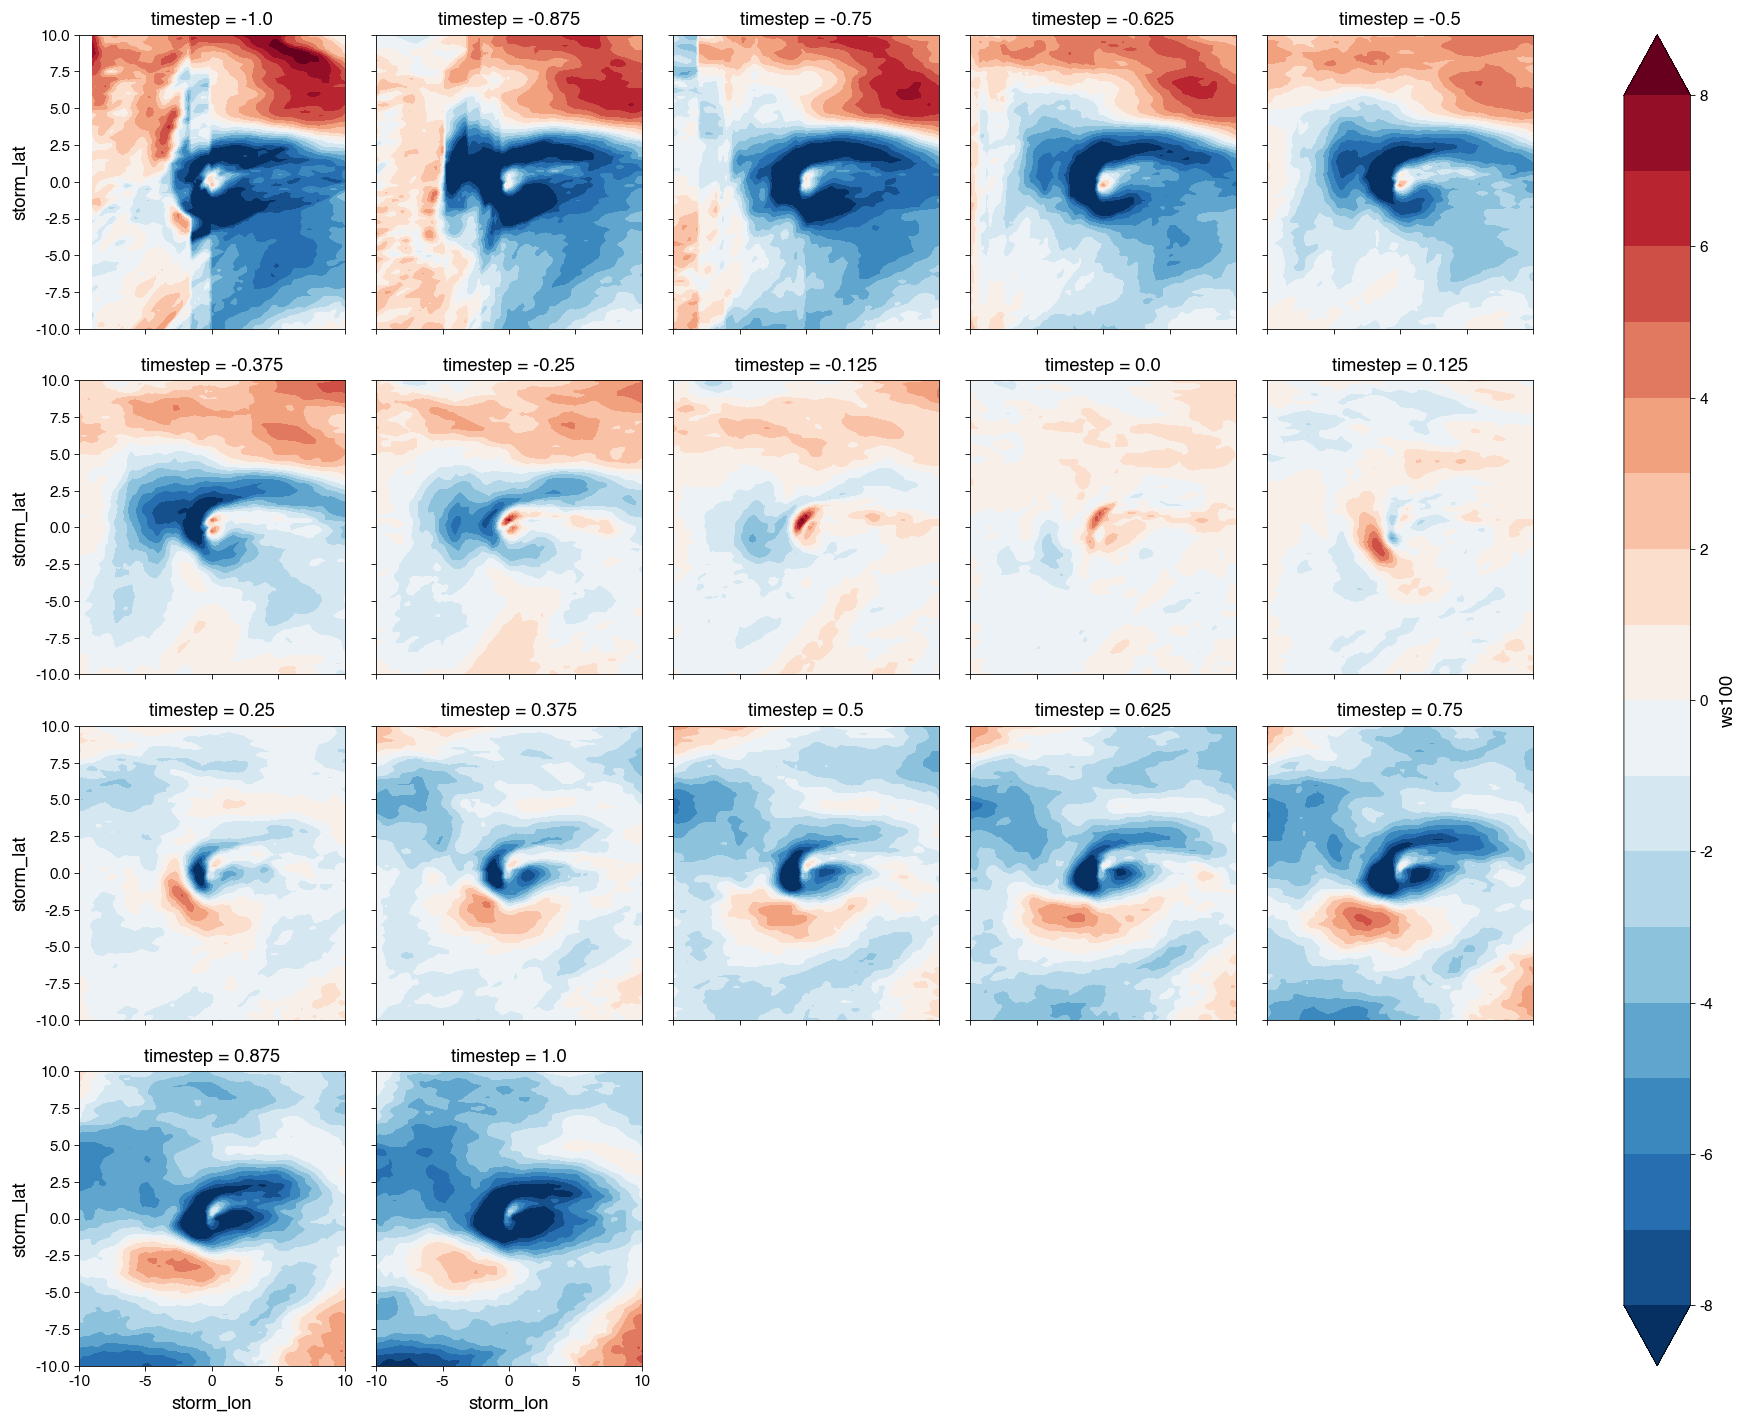

In [56]:
(incr_storms.ws100.sel(inidate="2022-02-16",timestep=slice(-1,1)).mean('number').squeeze() - pi_storms.ws100.sel(inidate="2022-02-16",timestep=slice(-1,1)).sel(timestep=0).mean('number').squeeze()).plot.contourf(col='timestep',col_wrap=5,levels=np.linspace(-8,8,17))

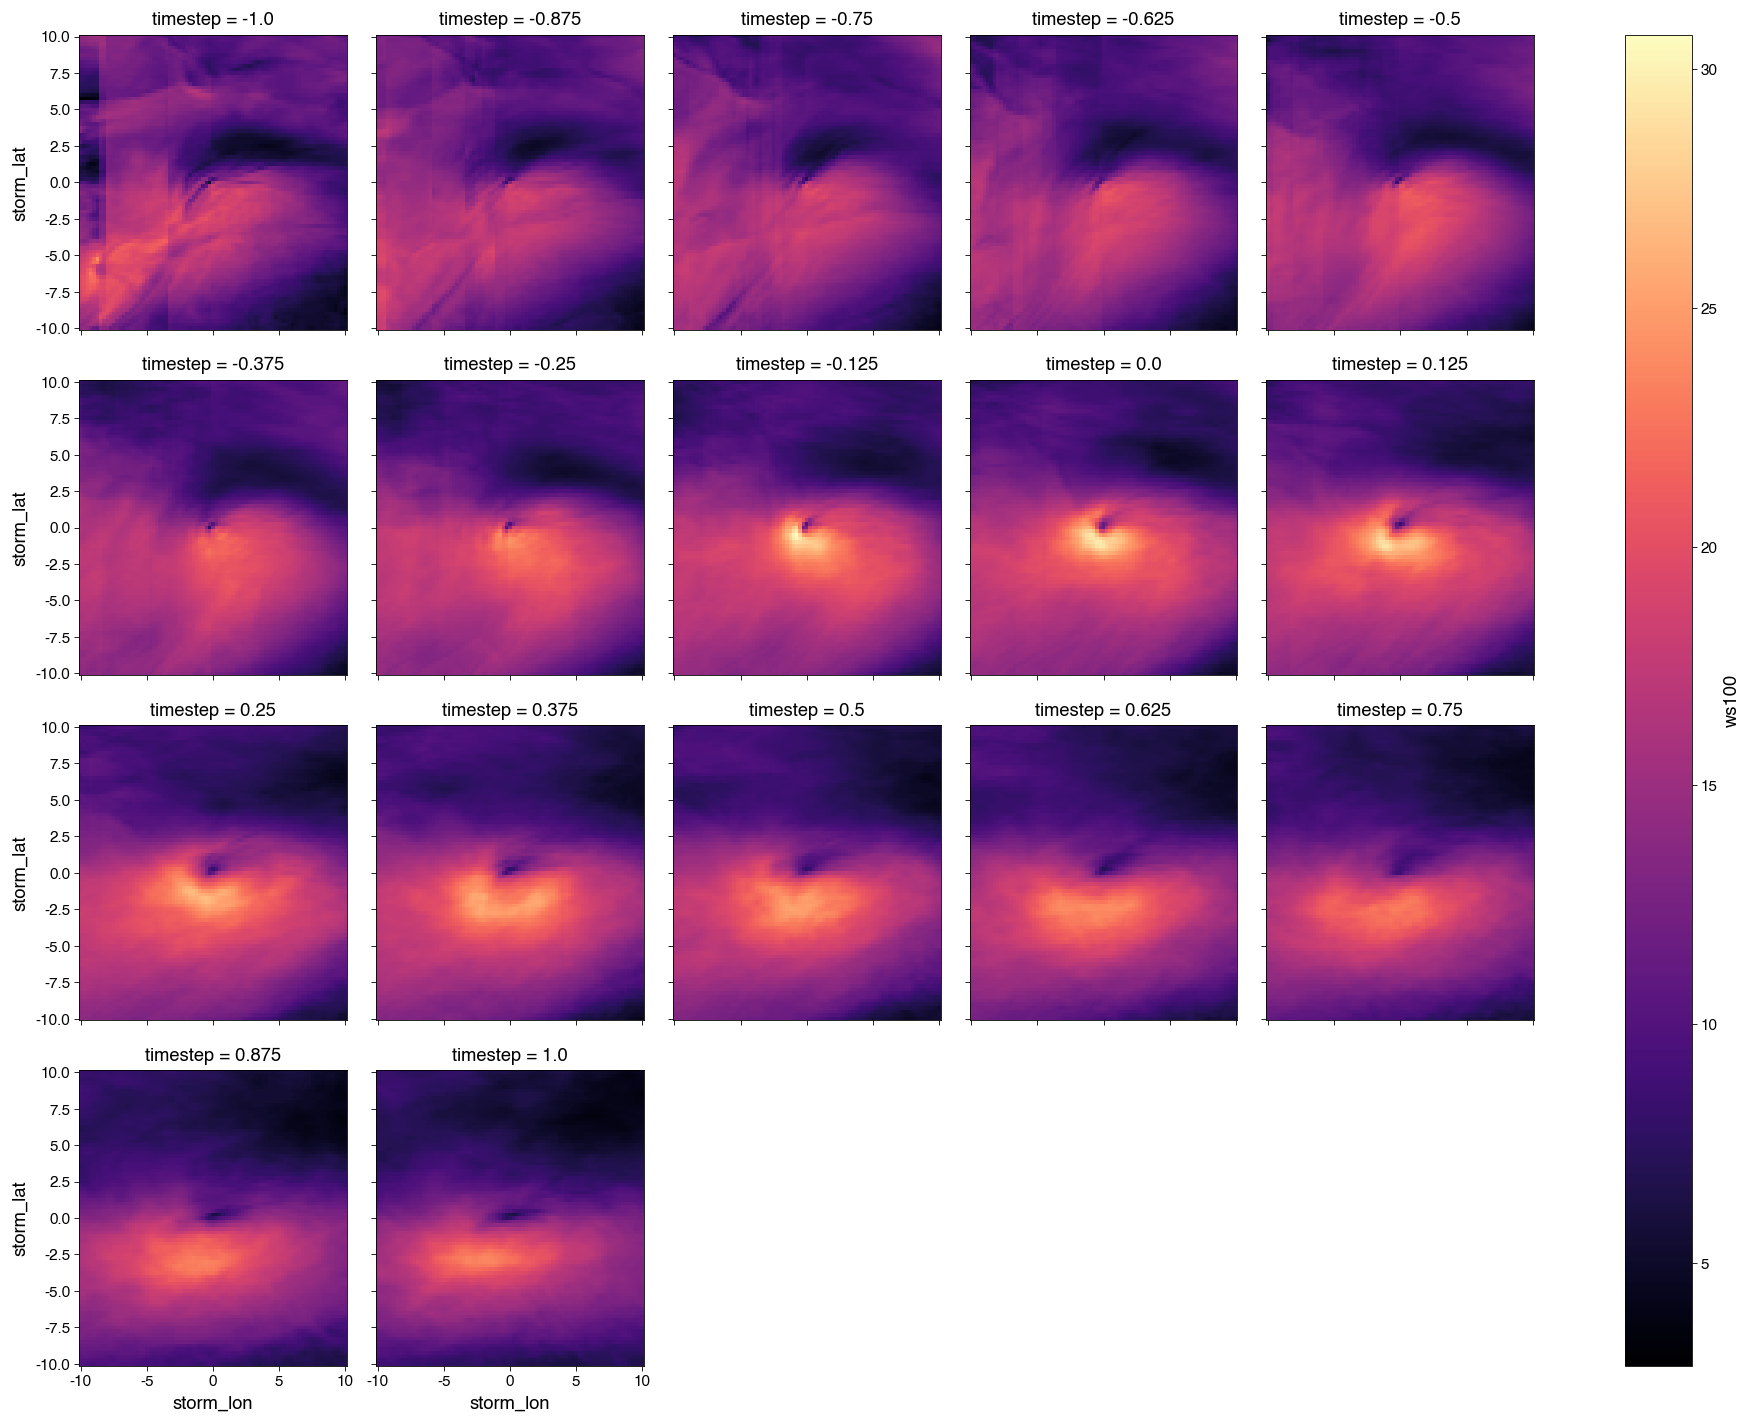

In [58]:
ens_storms.sel(inidate='2022-02-14',timestep=slice(-1,1)).ws100.mean('number').plot(col='timestep',cmap='magma',col_wrap=5)

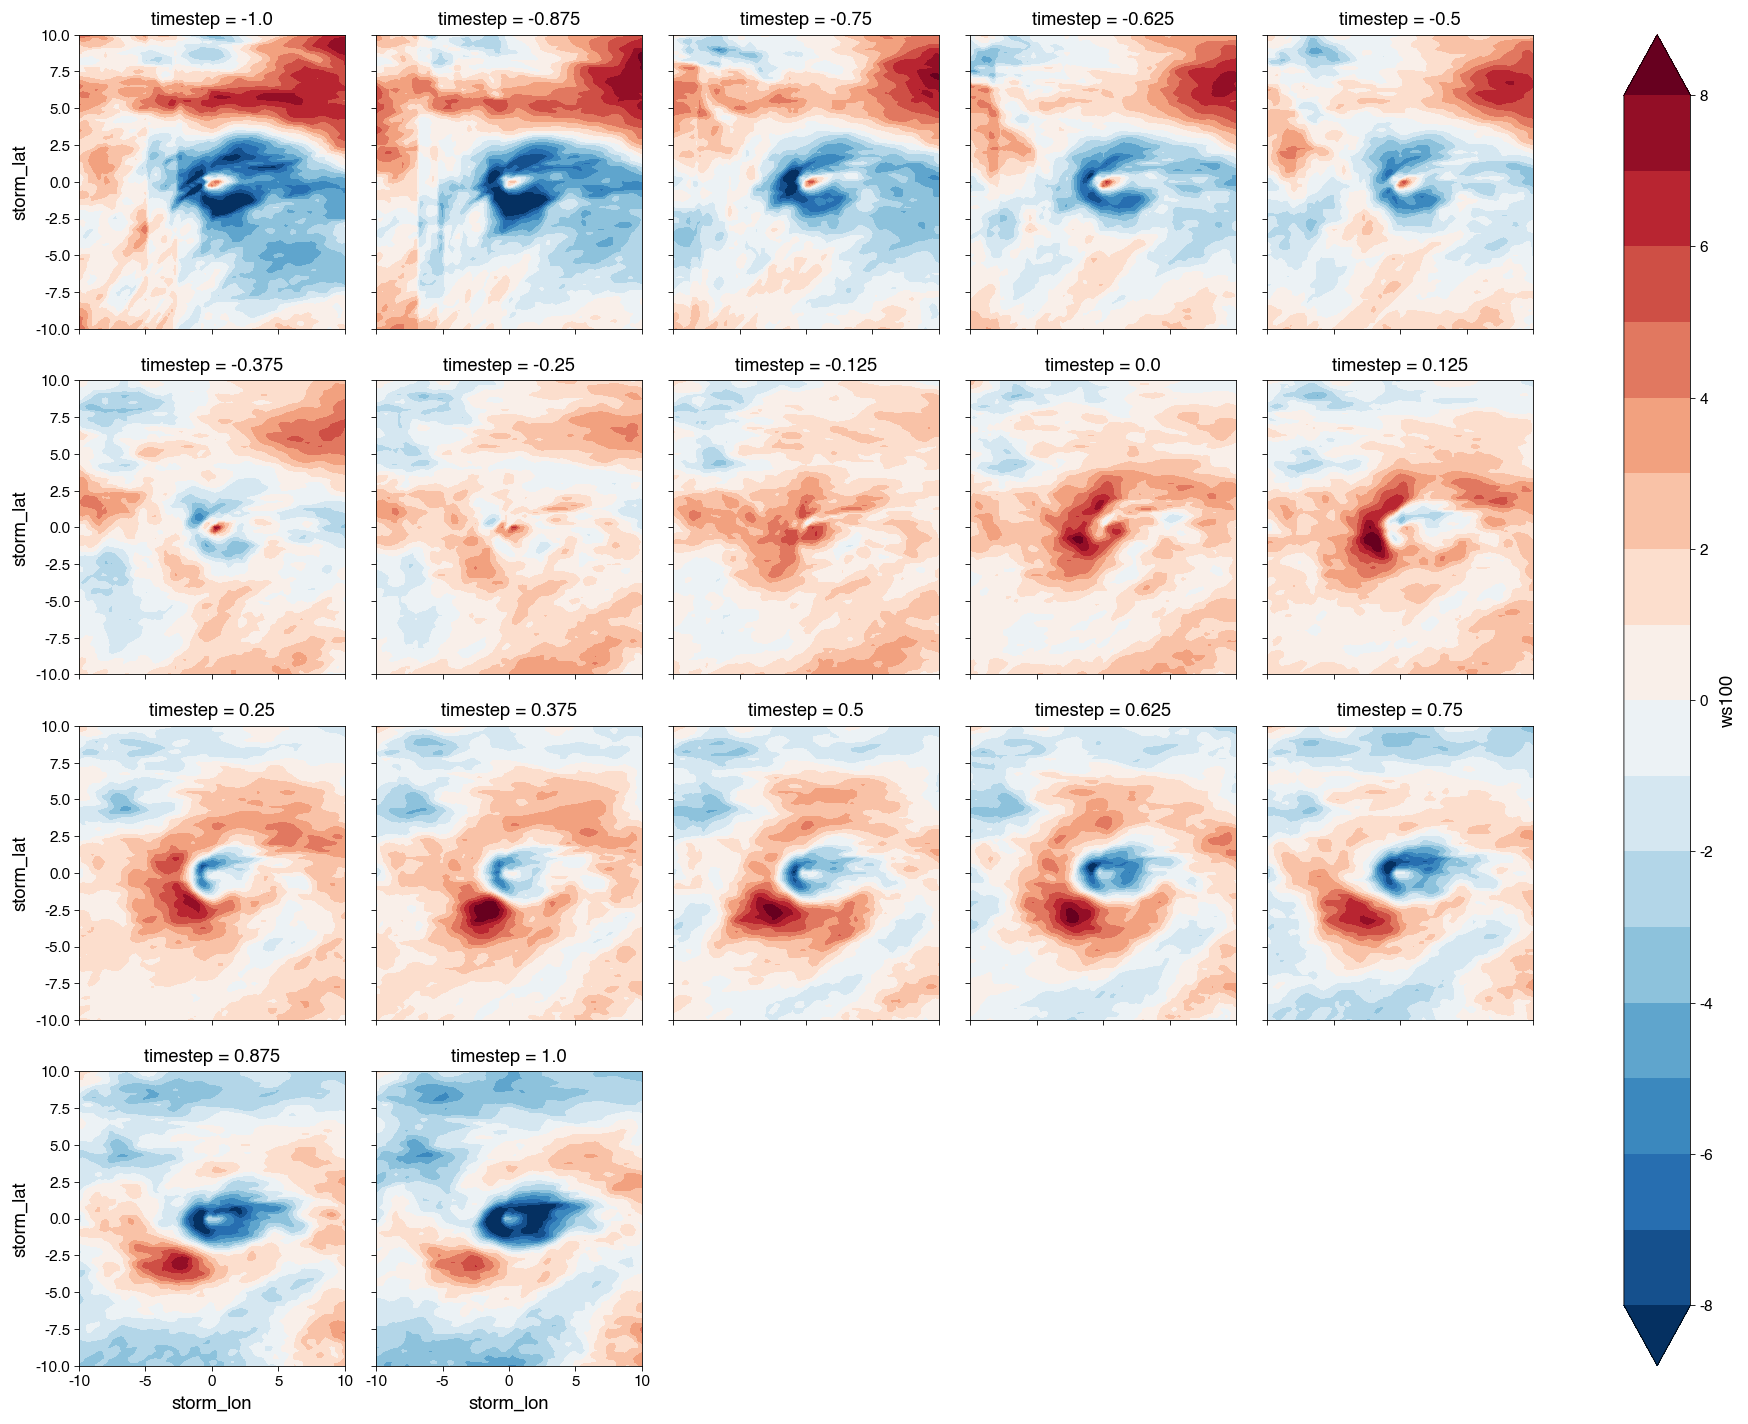

In [57]:
(incr_storms.ws100.sel(inidate="2022-02-14",timestep=slice(-1,1)).mean('number').squeeze() - pi_storms.ws100.sel(inidate="2022-02-14",timestep=slice(-1,1)).sel(timestep=0).mean('number').squeeze()).plot.contourf(col='timestep',col_wrap=5,levels=np.linspace(-8,8,17))

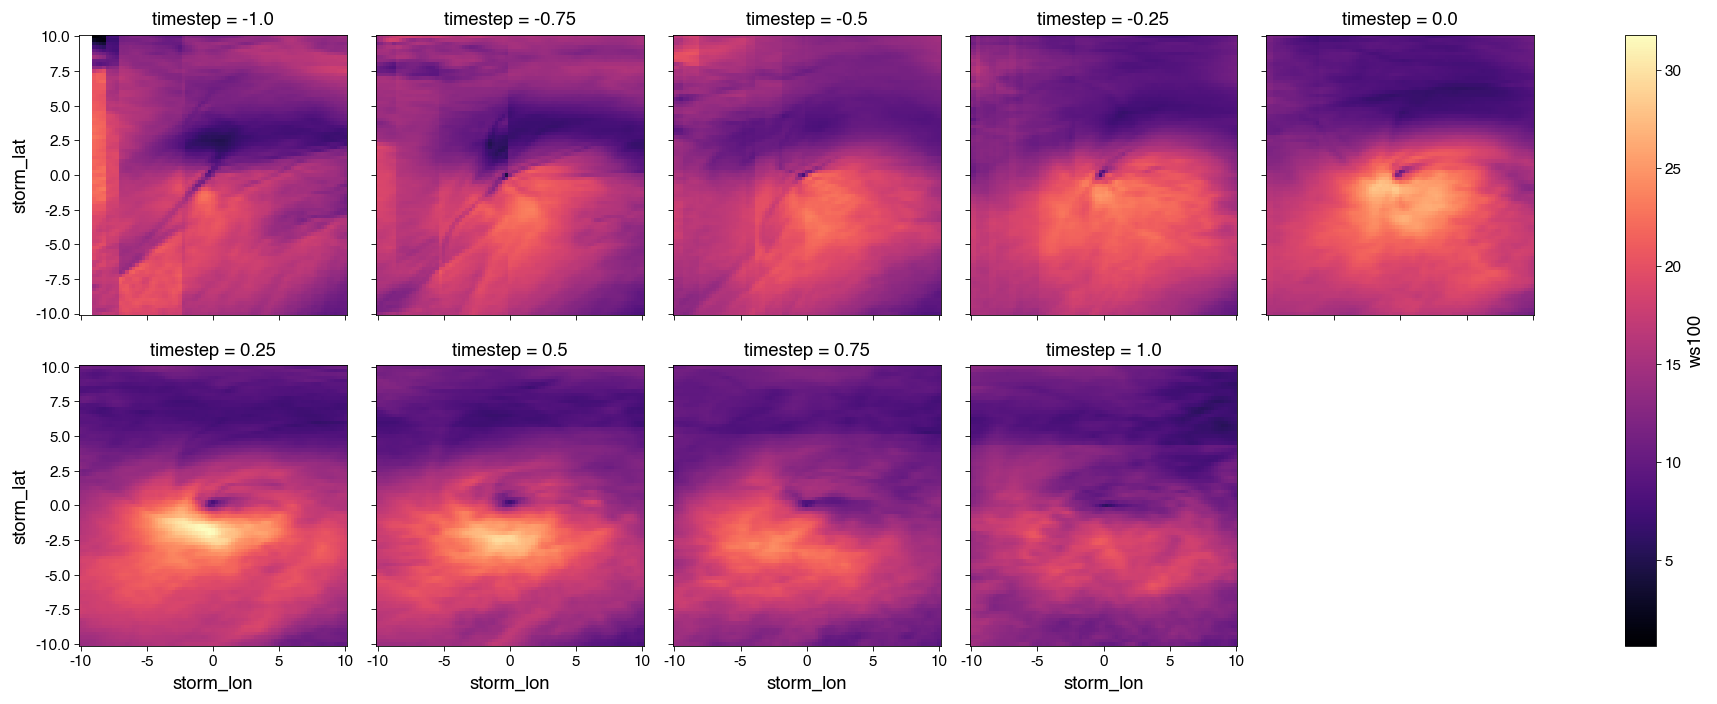

In [61]:
ens_storms.sel(inidate='2022-02-10',timestep=slice(-1,1)).dropna('timestep',how='all').ws100.mean('number').plot(col='timestep',cmap='magma',col_wrap=5)

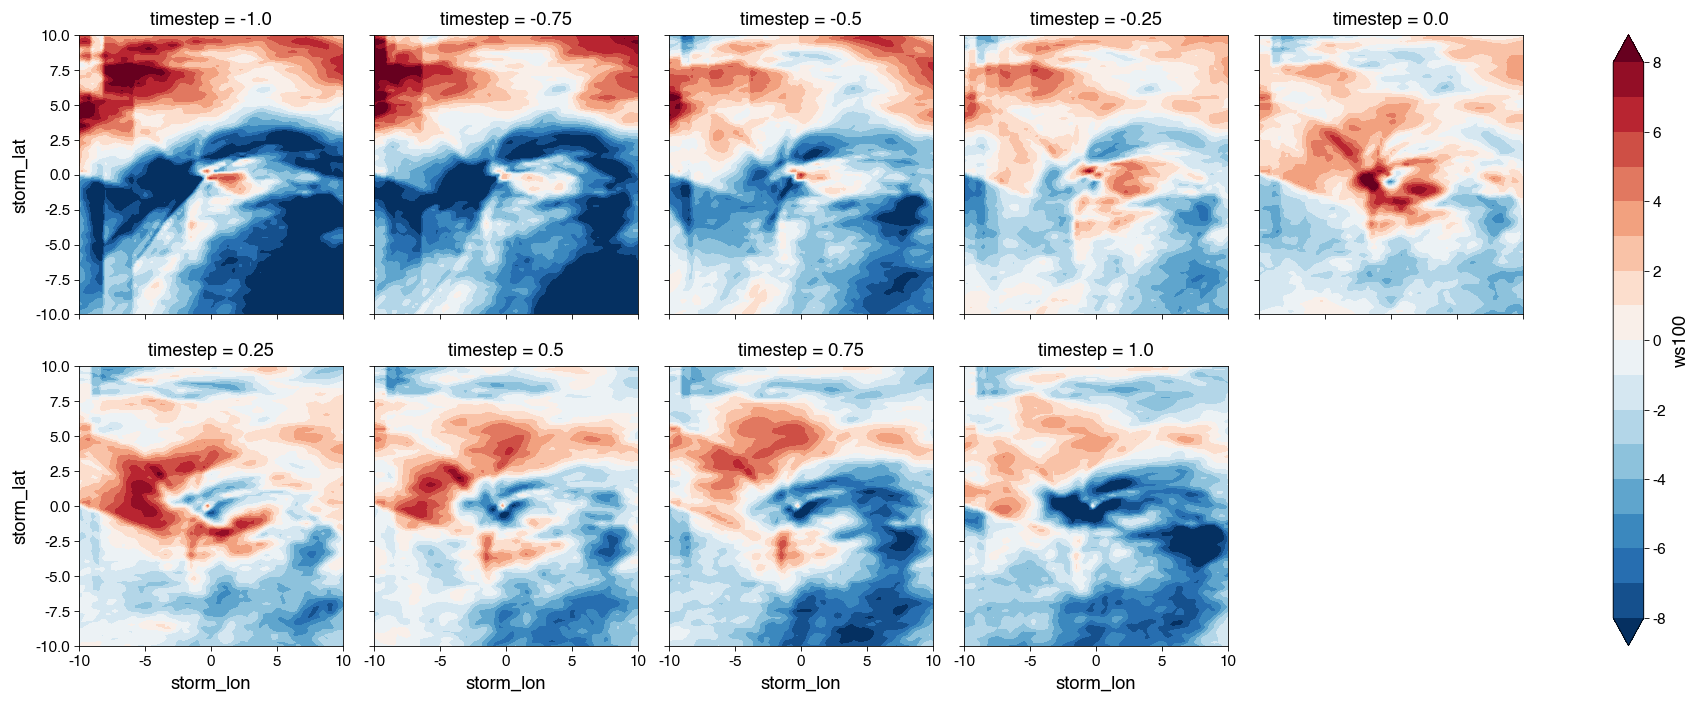

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [62]:
(incr_storms.ws100.sel(inidate="2022-02-10",timestep=slice(-1,1)).mean('number').squeeze() - pi_storms.ws100.sel(inidate="2022-02-10",timestep=slice(-1,1)).sel(timestep=0).mean('number').squeeze()).dropna('timestep',how='all').plot.contourf(col='timestep',col_wrap=5,levels=np.linspace(-8,8,17))

## Some thoughts:
- Wind speed strengthening with CC appears fairly robust over the two shortest leads.
- Increased number of Eunice-like tracks with CC (nb. bias in longest lead detection since operational forecast is based on 6hrly data)
- pi tracks in logest lead appear to have slight Northwards shift -> may explain the less clear picture wrt. intensity?
    - This Northward shift also messes with assessing how CC affects the deepening of the cyclone -> need to account for the background state?
- Looks like a CC may have very slightly affected min central pressure -> doubt statistically significant.
- From the *sprinkle* plot looks like CC may have resulted in more rapid intensification (peak vort) in mid lead.
- Definitely some interesting stuff going on with the wind response to CC:
    - Based on the composite changes relative to peak strength, lots of spatial structure to the response:
        - the areas of peak wind see more intense winds
        - regions northwards of the storm center see lower winds
        - quite possible this is consistent with a strengthening of the storm in general but need more thinking about the physics underlying cyclone life cycles
        - wind speeds in general considerably weaker both before and after storm